In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import os
import pandas as pd
import csv
import math
#import pickle

In [8]:
def is_school(detail):
    if 'academy' in detail.lower() or 'college' in detail.lower() or 'university' in detail.lower():
        return 1
    else:
        return 0

def is_job(detail):
    if ' at ' in detail.lower() or '.com' in detail.lower() or \
    ' inc' in detail.lower() or 'supervisor' in detail.lower() or \
    'consultant' in detail.lower() or 'physician' in detail.lower():
        return 1
    else:
        return 0

def school_or_job(detail):
    if ' at ' in detail.lower() or '.com' in detail.lower() or ' inc' in detail.lower():
        return 'job'
    elif 'academy' in d.lower() or 'college' in d.lower() or 'university' in d.lower():
        return 'school'
    else:
        return 'job'

def get_suitor_info(directory):
    path1 = directory.rpartition('\\')
    city = path1[2]
    #print(city)
    path2 = path1[0].rpartition('\\')
    sex = path2[2]
    #print(sex)
    path3 = path2[0].rpartition('\\')
    education_level = path3[2]
    #print(education_level)
    
    all_entries = {}
    #file_list= []
    like_list = []
    new_profile = []
    #my_dir = os.getcwd()

    #retrieve every record of a suitor from every profile#.html file
    #like_list is a list in which each element is a list of the details of a suitor
    for file in os.listdir(directory):
        if file.endswith(".html"):
            new_file_indicator = True
            #file_list.append(os.path.join(directory, file))
            profile = open(os.path.join(directory, file),'r',encoding='utf8',errors='ignore')
            source_code = profile.read()
            profile.close()
            soup = BeautifulSoup(source_code, 'html.parser')
            name_list = soup.find_all('span')
            profile_image_counter = 0
            background_images = {}
            for a in name_list:
                div_list = a.find_all('div')
                for aa in div_list:
                    keys = aa.attrs
                    if "style" in keys:
                        if "background-image" in aa["style"]:
                            profile_image_counter += 1
                            #split1 = aa["style"].rpartition("/")
                            #split2 = split1[2].rpartition('"')
                            split1 = aa["style"].partition('"')
                            split2 = split1[2].rpartition('"')
                            background_images[profile_image_counter] = split2[0]
                        
                keys = a.attrs
                if "class" in keys:
                    if new_file_indicator:
                        if new_profile:
                            like_list.append(new_profile)
                            new_profile = []
                        new_file_indicator = False
                        profile_counter = 0
                    if "recCard__name" in a["class"]:
                        like_list.append(new_profile)
                        new_profile = [file]
                        profile_counter += 1
                        new_profile.append(profile_counter)
                        if profile_counter in background_images.keys():
                            new_profile.append(background_images[profile_counter])
                        else:
                            print(directory)
                            print(file)
                            print(profile_counter)
                            print(background_images)
                            print()
                            new_profile.append(float('nan'))
                        new_profile.append(a.string)
                    elif "recCard__age" in a["class"]:
                        if bool(a.string):
                            new_profile.append(int(a.string[2:]))
                        else:
                            new_profile.append(a.string)
                    elif "Fz($ms)" in a["class"] or " W(100%)" in a["class"] or "D(b)" in a["class"]:
                        new_profile.append(a.string)
    if new_profile:
        like_list.append(new_profile)

    #organize all the records in like_list by filename
    #all_entries is a dictionary that has the filename as its key and a list of entries from like_list as its value
    #each list in like_list has at least 5 elements: filename, file position, profile image, name, and age
    #after these elements, we insert num_details (count of additional details), school (1 if reported),
    #job (1 if reported), num_ig (# ig photos listed), and unknown (count of unidentified details)
    profile_number = 'blah'
    for b in like_list:
        num_details = 0
        num_ig = float('nan')
        school = 0
        job = 0
        unknown = 0
        current_entry = []
        details = []
        if b:
            current_entry = b[1:5]
            num_details = len(b)-5
            #current_entry.append(num_details)
            if num_details > 0:
                details = b[5:]
                for c in details:
                    if is_school(c):
                        school = 1
                    elif is_job(c):
                        job = 1
                    elif ' instagram photos' in c.lower():
                        #num_ig = int(c.partition(" ")[0])
                        num_ig = c.partition(" ")[0]
                        num_ig = int(num_ig.replace(',',''))
                    else:
                        unknown += 1
                #b = b[:5] + blah + b[5:]
            #else:
                #b.append(num_details)
            
            current_entry.extend([num_details, school, job, num_ig, unknown]+details)
            #print(current_entry)
            
            if b[0] != profile_number:
                profile_number = b[0]
                all_entries[profile_number] = []
            #all_entries[profile_number].append(b[1:])
            all_entries[profile_number].append(current_entry)

    #get the 2nd suitor record of each file
    #suitor_list is the actual list of liked suitors
    num_columns = 0
    suitor_list = []
    for c in all_entries:
        suitor = [c]
        suitor.extend(all_entries[c][1])
        suitor_list.append(suitor)
        if len(all_entries[c][1]) > num_columns:
            num_columns = len(all_entries[c][1])

    #make number of columns data dependent
    #columns = ['filename', 'file_position', 'profile_image','name', 'age']
    columns = ['filename', 'file_position', 'profile_image','name', 'age', 
               'num_details', 'school', 'job', 'num_ig', 'unknown']
    detail_number = 1
    while len(columns) <= num_columns:
        columns.append('detail_' + str(detail_number))
        detail_number += 1

    #write the record of every swipe
    suitor_df = pd.DataFrame(suitor_list,columns=columns)
    suitor_df.to_csv('all_suitors.csv', header=True, index=False)

    #fill in missing values to enable counting of unique profiles
    suitor_df = suitor_df.fillna('NO DATA')

    #count the number of unique profiles
    #write the record of unique profiles in the run, including the number of times that profile appears
    #groupby_list = columns[1:]
    groupby_list = columns[2:]
    unique_suitors = suitor_df.groupby(groupby_list)['filename'].count()
    unique_suitors_filename = education_level + '_' + sex + \
                           '_' + city + '_unique_suitors.csv'
    unique_suitors.to_csv(unique_suitors_filename, header=True)
    
    #read the csv back in to make the df easier to work with
    #current_suitors = pd.read_csv(unique_suitors_filename)
    current_suitors = unique_suitors.reset_index()
    current_suitors['swipes'] = current_suitors['filename']
    current_suitors = current_suitors.drop('filename', axis=1)
    current_suitors = current_suitors.replace({'NO DATA': float('nan')}, regex=True)
    covariates = ['noedu', 'bs', 'md', 'phd', 'associates', \
                  'female', 'male', \
                  'chicago', 'houston', 'losangeles', 'newyork', \
                  'philadelphia', 'phoenix', 'sanantonio', 'sandiego']
    for a in covariates:
        if (a == sex.lower()) or (a == city.lower()) or (a == education_level.lower()):
            current_suitors[a] = pd.Series([1 for b in range(current_suitors.shape[0])], index=current_suitors.index)
        else:
            current_suitors[a] = pd.Series([0 for b in range(current_suitors.shape[0])], index=current_suitors.index)

    #write the record of profiles that appeared more than once during the run
    duplicate_suitors = unique_suitors[unique_suitors>1]
    duplicate_suitors.to_csv('duplicate_suitors.csv', header=True)

    #write all records of all suitors in every profile#.html file
    #not sure how to handle strange characters-- ignoring for now
    with open('original_suitor_records.csv', 'w', newline='',errors='ignore') as original_suitor_records:
        wr = csv.writer(original_suitor_records)
        wr.writerow(columns)
        for d in like_list:
            if d:
                wr.writerow(d)
    
    return unique_suitors, duplicate_suitors, suitor_df, all_entries, current_suitors

In [9]:
all_unique_suitors = pd.DataFrame()
complete_records = {}
directories = os.walk(os.getcwd())
for folder in directories:
    #print(folder)
    current_dir = folder[0]
    subfolders = folder[1]
    contents = folder[2]
    if contents:
        if any('.html' in file for file in contents):
            complete_records[current_dir] = get_suitor_info(current_dir)
            current_suitors = complete_records[current_dir][4]
            all_unique_suitors = all_unique_suitors.append(current_suitors, ignore_index=True)

columns = ['profile_image', 'name', 'age', 'detail_1', \
           'detail_2', 'swipes', 'num_details', 'num_ig', \
           'school', 'job', 'unknown', 'noedu', \
           'bs', 'md', 'phd', 'associates', \
           'female', 'male', 'chicago', 'houston', \
           'losangeles', 'newyork', 'philadelphia', 'phoenix', \
           'sanantonio', 'sandiego']
all_unique_suitors = all_unique_suitors[columns]
all_unique_suitors.to_csv('all_unique_suitors.csv', header=True, index=False)

C:\MIDS\W241\final_project\Analysis\NoEdu\Female\LosAngeles
profile22.html
2
{1: 'https://images-ssl.gotinder.com/5921f5ddcee27fe44804a4cf/1080x1080_0b4d5a53-4104-4ded-8b40-7aebae9cd74d.jpg'}

C:\MIDS\W241\final_project\Analysis\NoEdu\Female\LosAngeles
profile22.html
3
{1: 'https://images-ssl.gotinder.com/5921f5ddcee27fe44804a4cf/1080x1080_0b4d5a53-4104-4ded-8b40-7aebae9cd74d.jpg'}

C:\MIDS\W241\final_project\Analysis\NoEdu\Female\LosAngeles
profile23.html
1
{}

C:\MIDS\W241\final_project\Analysis\NoEdu\Female\LosAngeles
profile23.html
2
{}

C:\MIDS\W241\final_project\Analysis\NoEdu\Female\LosAngeles
profile23.html
3
{}

C:\MIDS\W241\final_project\Analysis\NoEdu\Female\Philadelphia
profile72.html
2
{1: 'https://images-ssl.gotinder.com/55994b449255da0d4e22aa59/599fca0e-bedf-4cdd-8547-a7c4d48a4f9b.jpg'}

C:\MIDS\W241\final_project\Analysis\NoEdu\Female\Philadelphia
profile72.html
3
{1: 'https://images-ssl.gotinder.com/55994b449255da0d4e22aa59/599fca0e-bedf-4cdd-8547-a7c4d48a4f9b.jpg'}

C

In [11]:
all_columns = all_unique_suitors.columns.tolist()
print(len(all_columns))

26


In [12]:
columns = ['profile_image', 'name', 'age', 'detail_1', \
           'detail_2', 'swipes', 'num_details', 'num_ig', \
           'school', 'job', 'unknown', 'noedu', \
           'bs', 'md', 'phd', 'associates', \
           'female', 'male', 'chicago', 'houston', \
           'losangeles', 'newyork', 'philadelphia', 'phoenix', \
           'sanantonio', 'sandiego']
print(len(all_columns))

26


In [14]:
all_unique_suitors = all_unique_suitors[columns]
all_unique_suitors.to_csv('all_unique_suitors.csv', header=True, index=False)

In [4]:
len(complete_records.keys())

56

In [21]:
#plt.figure(figsize=(12,8))
#fontdict = {'fontsize': 16}
summary_statistics = []
for d in complete_records:
    edu_sex_city_df = complete_records[d][2]
    old_index = [f for f in range(len(edu_sex_city_df))]
    #print(len(edu_sex_city_df))
    edu_sex_city_df = edu_sex_city_df.drop(['filename', 'file_position'], axis=1)
    edu_sex_city_df = edu_sex_city_df.drop_duplicates()
    #print(edu_sex_city_df)
    #new_index = [f for f in range(len(edu_sex_city_df))]
    #edu_sex_city_df = edu_sex_city_df.reindex(new_index)
    edu_sex_city_df = edu_sex_city_df.reindex(old_index)
    #edu_sex_city_df = edu_sex_city_df.reindex()
    
    suitor_ages = edu_sex_city_df['age']
    num_suitors = len(complete_records[d][0])
    if suitor_ages.dtypes == 'object':
        for f in range(len(suitor_ages)):
            #print(type(f))
            if type(suitor_ages[f]) is str:
                suitor_ages[f] = float('nan')
    
    #edu_sex_city_df['num_details'].hist()
    num_suitors_with_details = sum(edu_sex_city_df['num_details'] > 0)
    
    #edu_sex_city_df['school'].hist()
    num_suitors_with_school = sum(edu_sex_city_df['school'] > 0)
    
    #edu_sex_city_df['job'].hist()
    num_suitors_with_job = sum(edu_sex_city_df['job'] > 0)
    
    #edu_sex_city_df['num_ig'].hist()
    #edu_sex_city_df['unknown'].hist()
    num_suitors_with_unknowns = sum(edu_sex_city_df['unknown'] > 0)
    total_unknowns = int(edu_sex_city_df['unknown'].sum())
        
    #suitor_num_ig = list(edu_sex_city_df['num_ig'])
    suitor_num_ig = list(edu_sex_city_df['num_ig'])
    #num_with_ig = sum((type(a) is int or (type(a) is float) and not math.isnan(a)) for a in suitor_num_ig)
    ig_counts = list(a for a in suitor_num_ig if (type(a) is int or (type(a) is float) and not math.isnan(a)))
    num_with_ig = len(ig_counts)
    #print(ig_counts)
    #print(num_with_ig, 'suitors included IG photos.')
    
    
    #
    current_condition = [d, num_suitors, num_suitors_with_details, \
                         num_suitors_with_school, num_suitors_with_job, \
                         num_with_ig, num_suitors_with_unknowns, total_unknowns]
    summary_statistics.append(current_condition)
    
    
#    all_plots = plt.figure(d, figsize=(18,12))
#    #plt.title(d + ', ' + str(num_suitors))
#    sp = plt.subplot(321)
#    #sp = all_plots.subplot(321)
#    #print(len(edu_sex_city_df))
#    edu_sex_city_df['age'].hist()
#    sp.set_title('Ages', fontdict=fontdict)
#    
#    sp = plt.subplot(322)
#    #sp = all_plots.subplot(322)
#    edu_sex_city_df['num_details'].hist()
#    sp.set_title('Number of Details', fontdict=fontdict)
#    
#    sp = plt.subplot(323)
#    #sp = all_plots.subplot(323)
#    edu_sex_city_df['school'].hist()
#    sp.set_title('School Count', fontdict=fontdict)
#    
#    sp = plt.subplot(324)
#    #sp = all_plots.subplot(324)
#    edu_sex_city_df['job'].hist()
#    sp.set_title('Job Count', fontdict=fontdict)
#    
#    sp = plt.subplot(325)
#    #sp = all_plots.subplot(325)
#    pd.Series(ig_counts).hist()
#    sp.set_title('IG Photos', fontdict=fontdict)
#    
#    sp = plt.subplot(326)
#    #sp = all_plots.subplot(326)
#    edu_sex_city_df['unknown'].hist()
#    sp.set_title('Number of Unknowns', fontdict=fontdict)
#    
#    #plt.title(d + ', ' + str(num_suitors))
#    all_plots.suptitle(d + ', ' + str(num_suitors) + '\n' + \
#                       str(num_with_ig) + ' suitors included IG photos.' + '\n' + \
#                       str(num_suitors_with_details) + ' suitors included details beyond name and age.' + '\n' + \
#                       str(num_suitors_with_school) + ' schools and ' + \
#                       str(num_suitors_with_job) + ' jobs were identified.' + '\n' + \
#                       str(num_suitors_with_unknowns) + ' suitors have at least one unidentified detail (' + \
#                       str(total_unknowns) + ' total unidentified details).', y=1.05, fontsize=20)
#    #print()

columns = ['folder', 'num_suitors', 'num_suitors_with_details', \
          'num_suitors_with_school', 'num_suitors_with_job', \
          'num_with_ig', 'num_suitors_with_unknowns', 'total_unknowns']
summary = pd.DataFrame(summary_statistics, columns=columns)
summary.to_csv('summary_statistics.csv', header=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


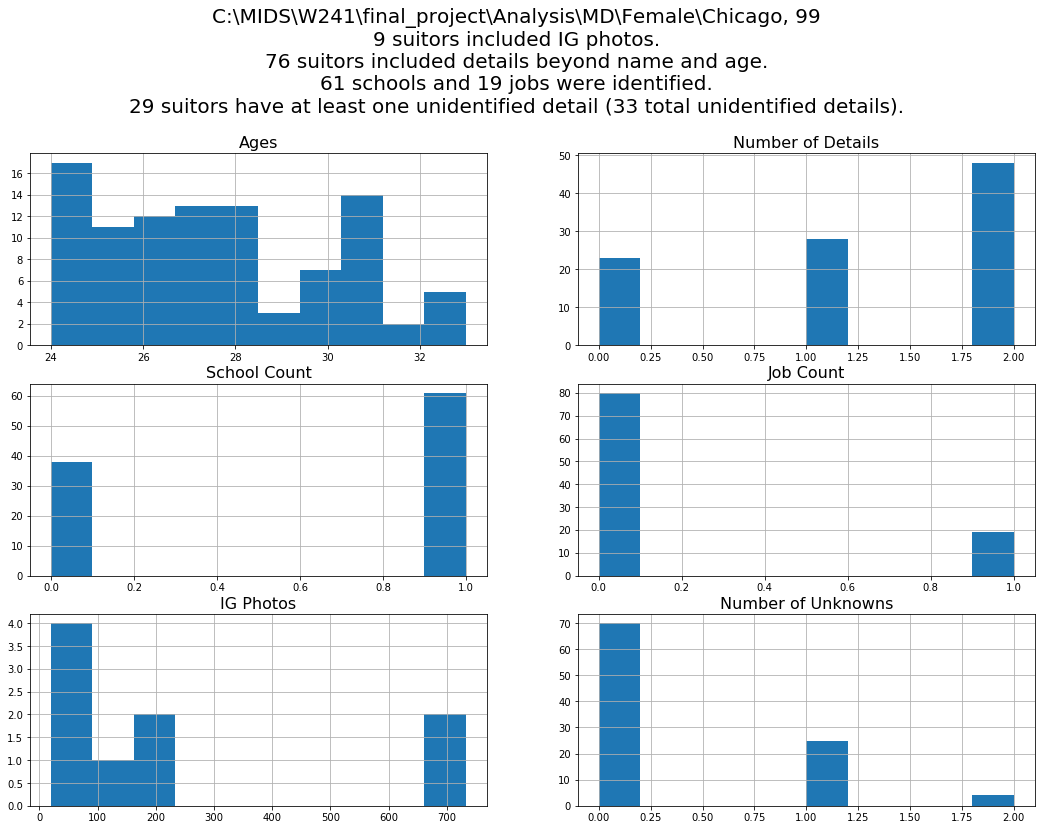

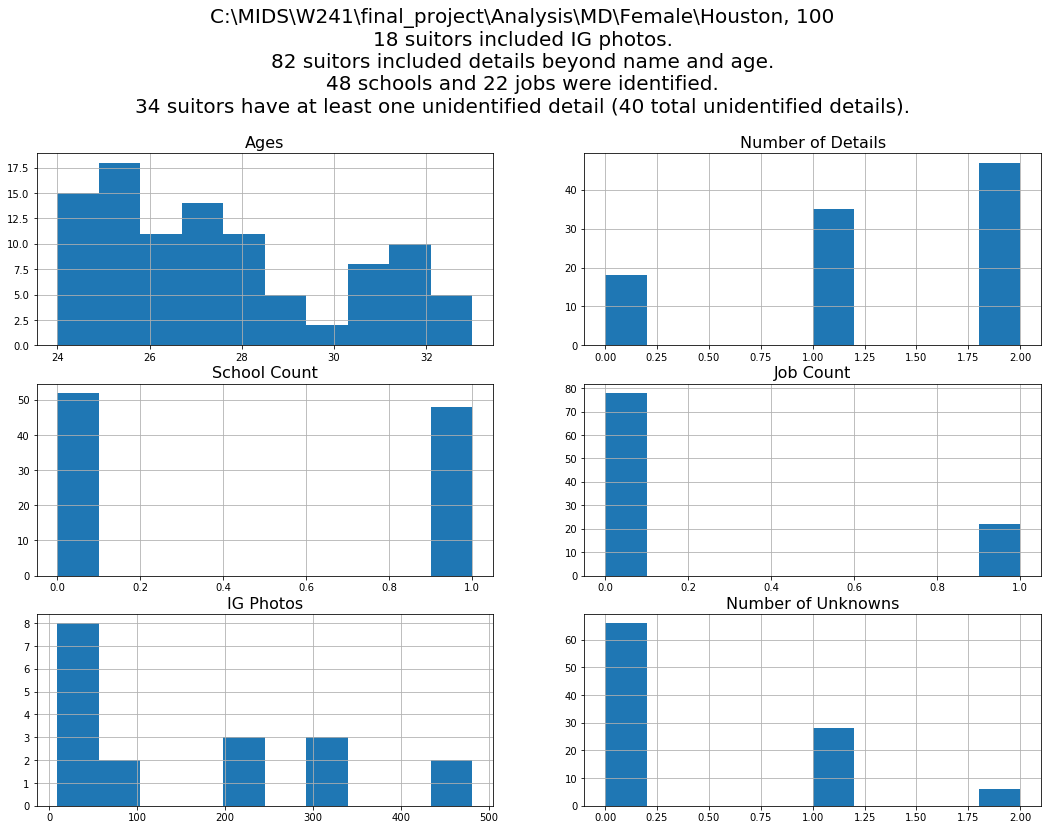

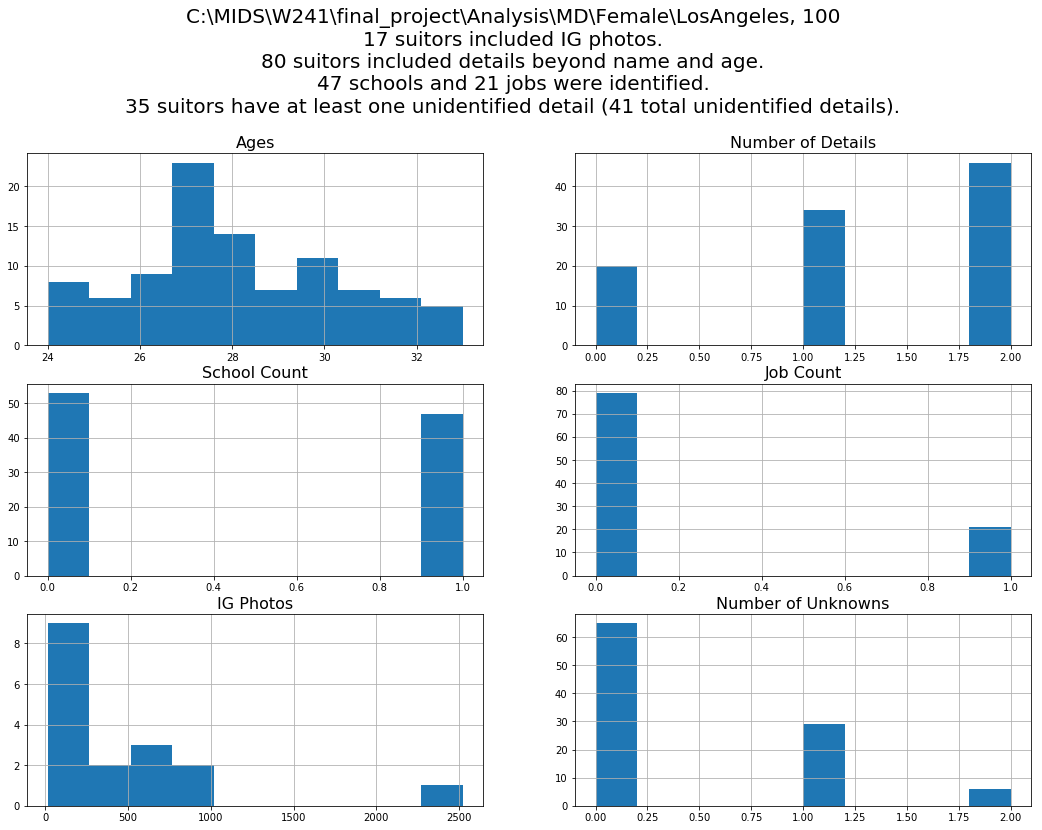

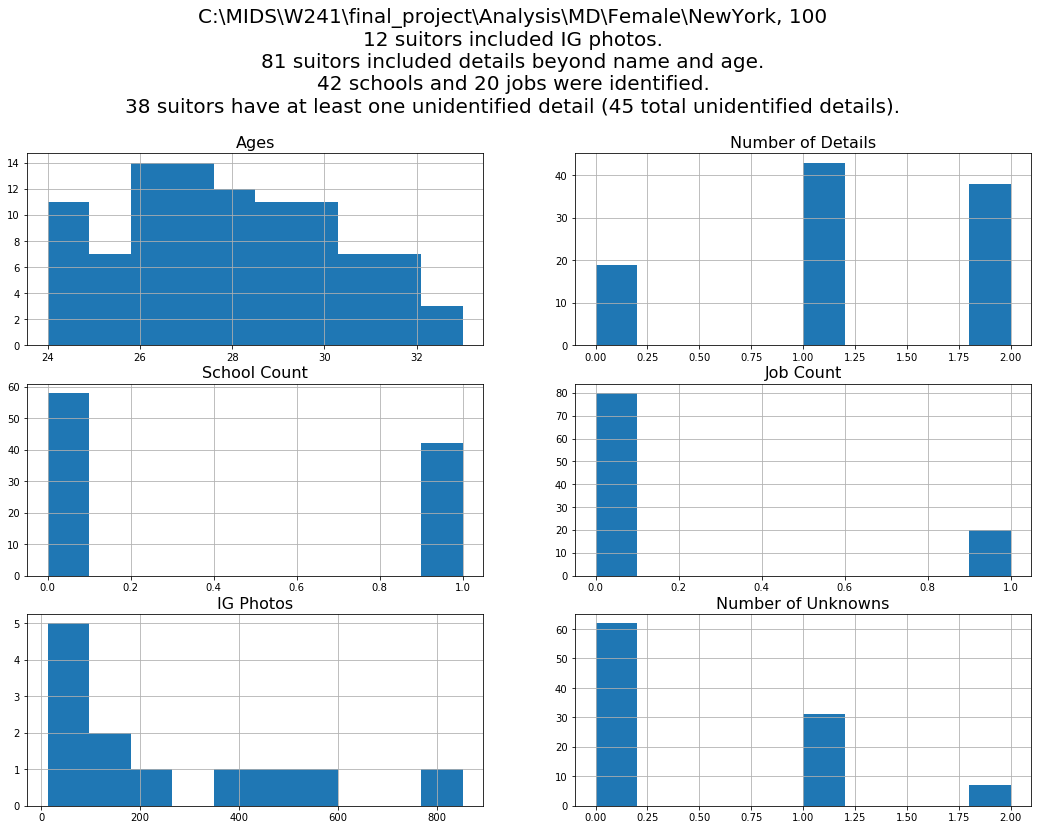

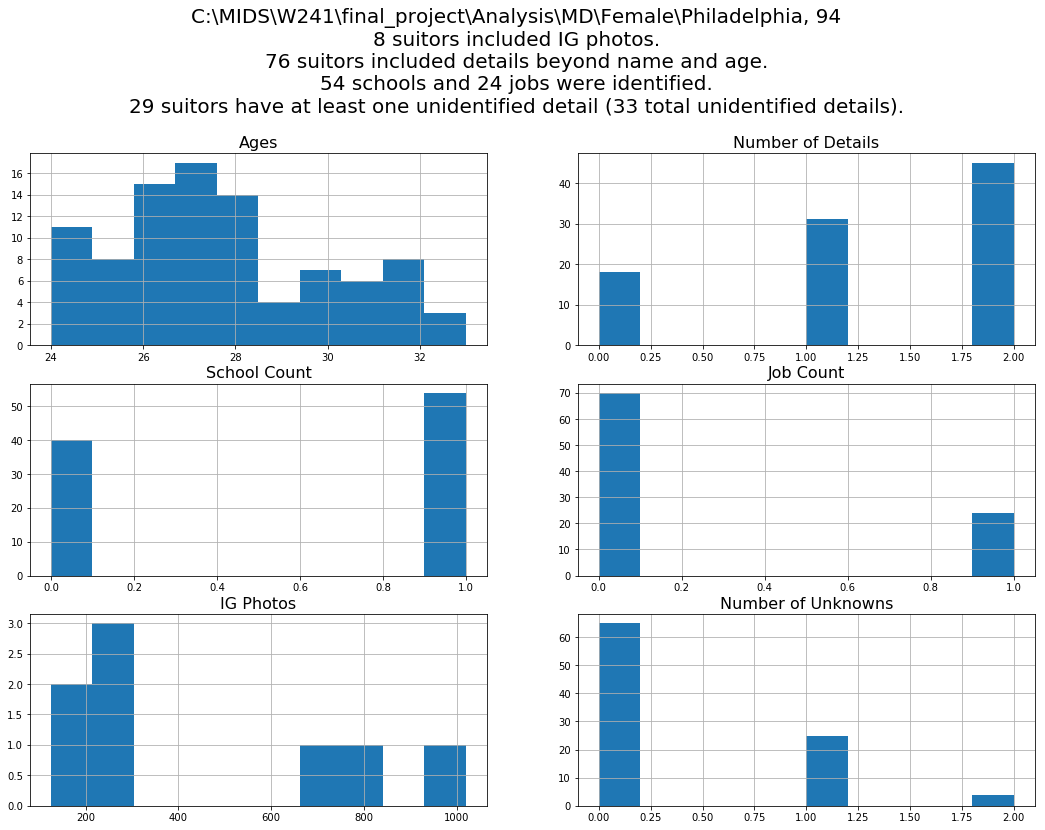

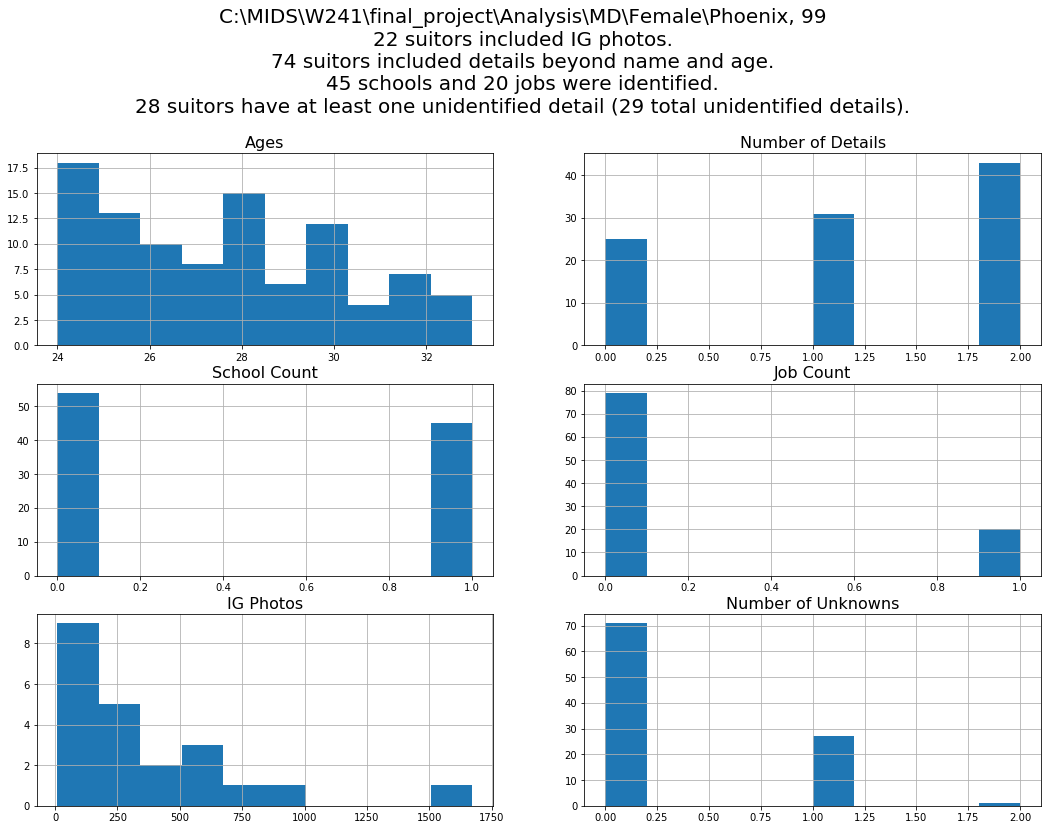

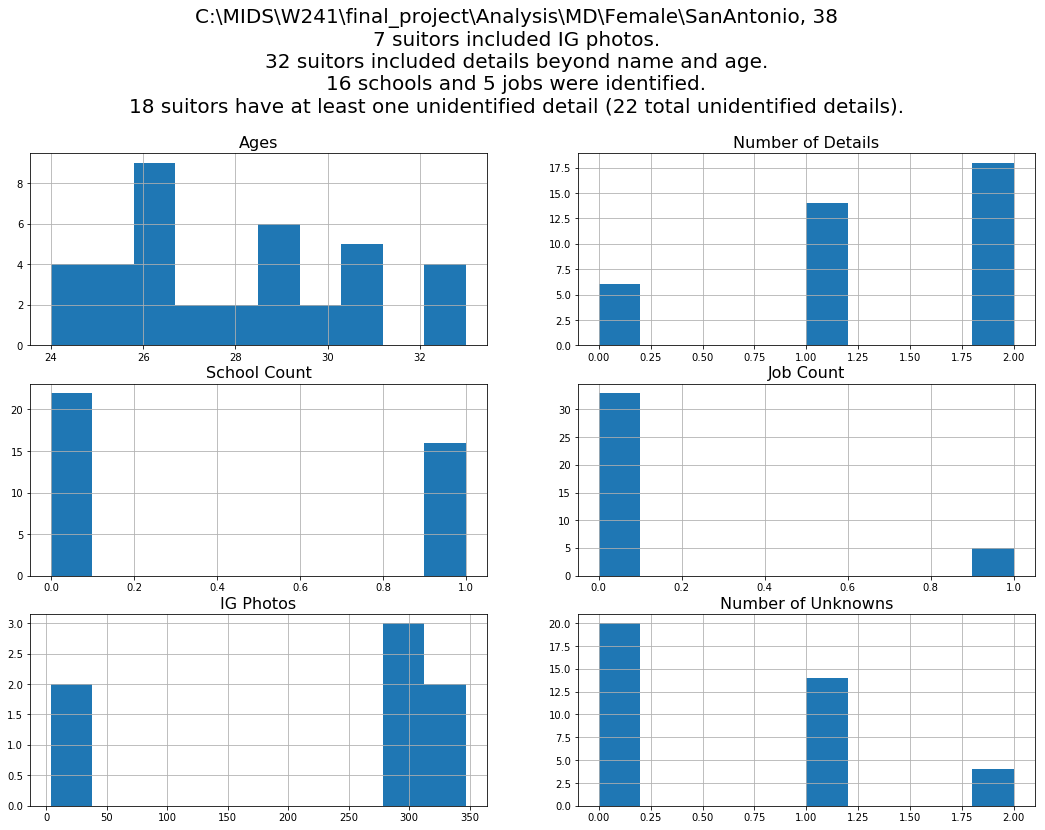

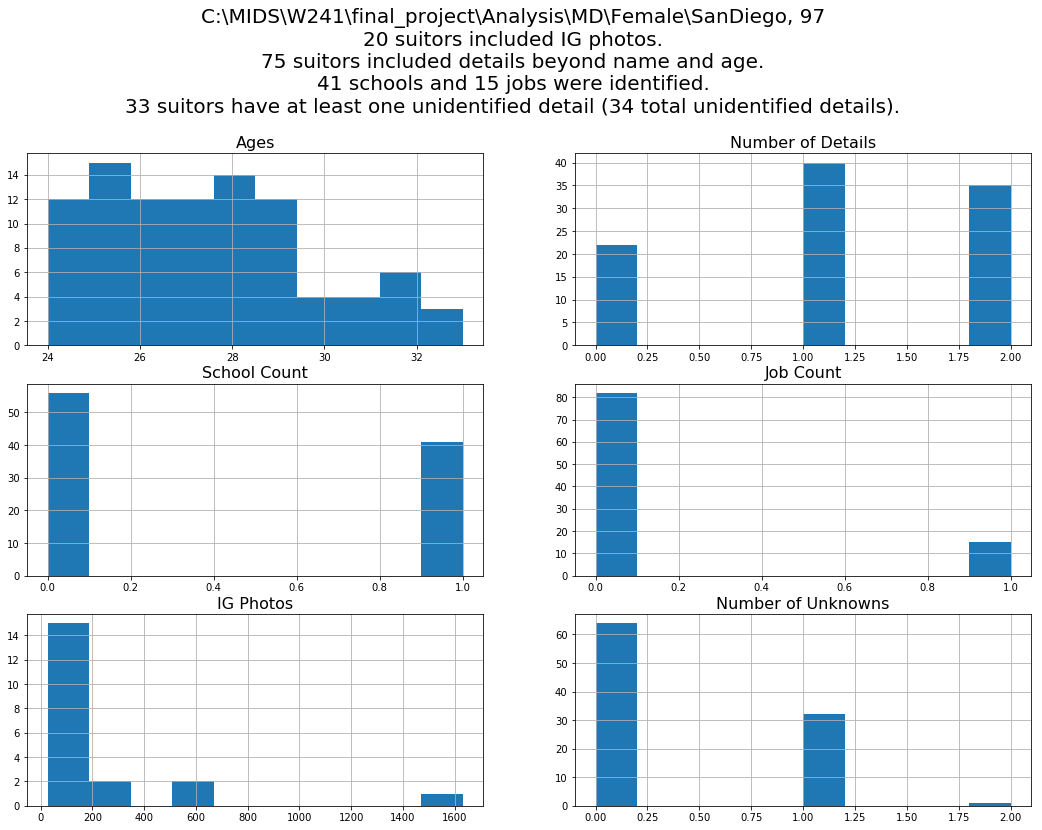

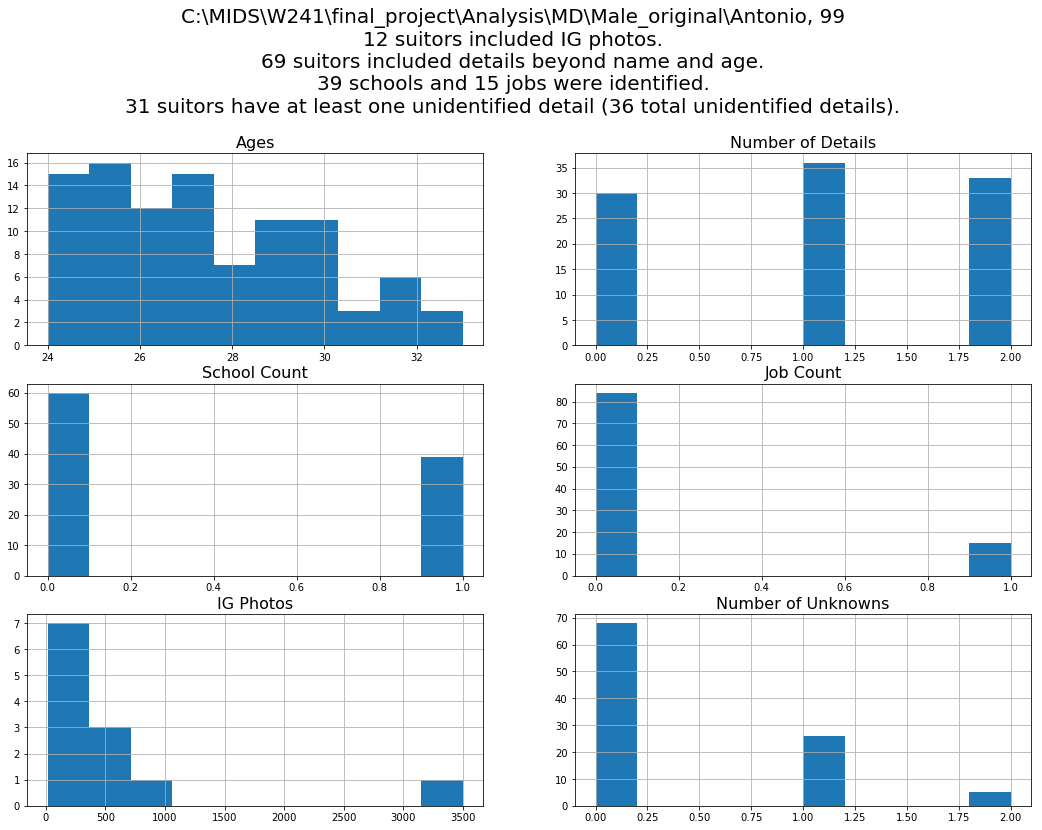

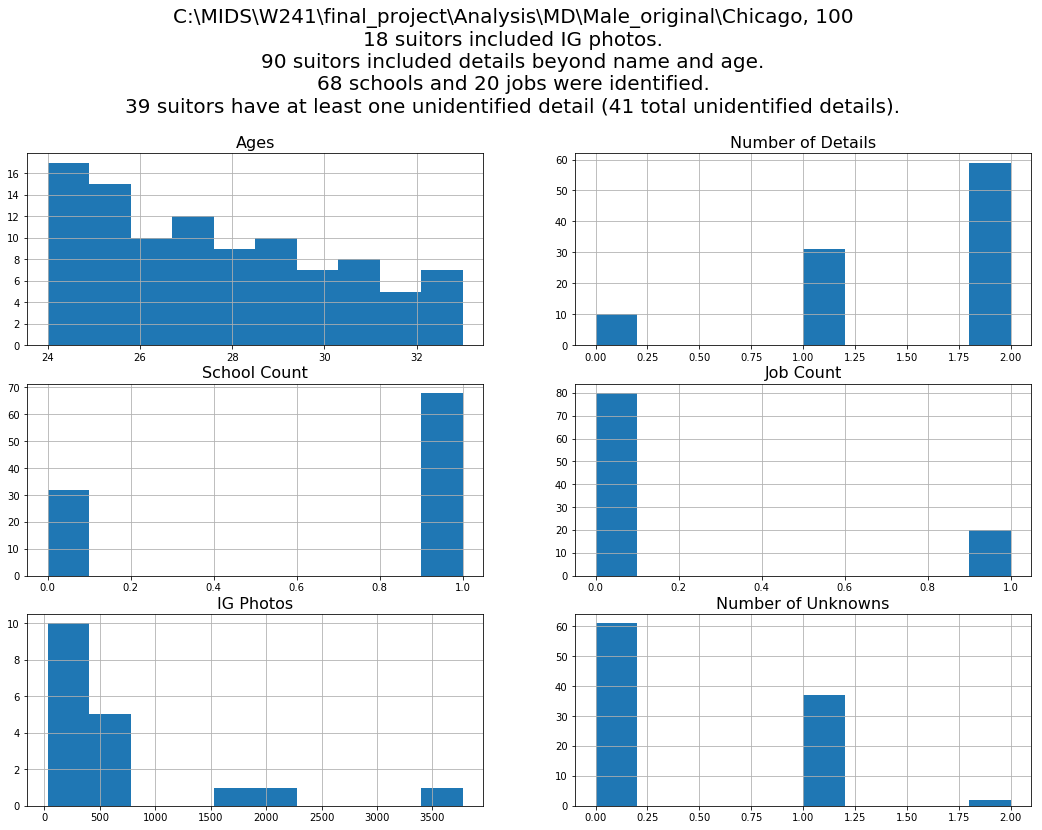

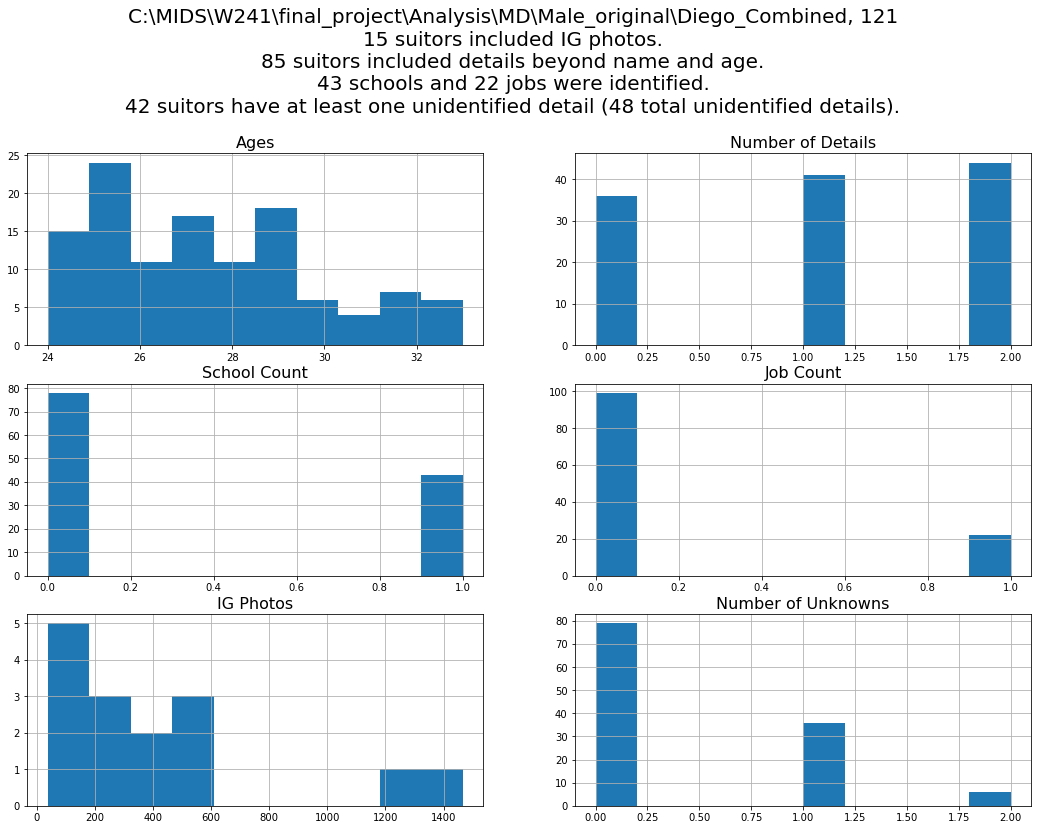

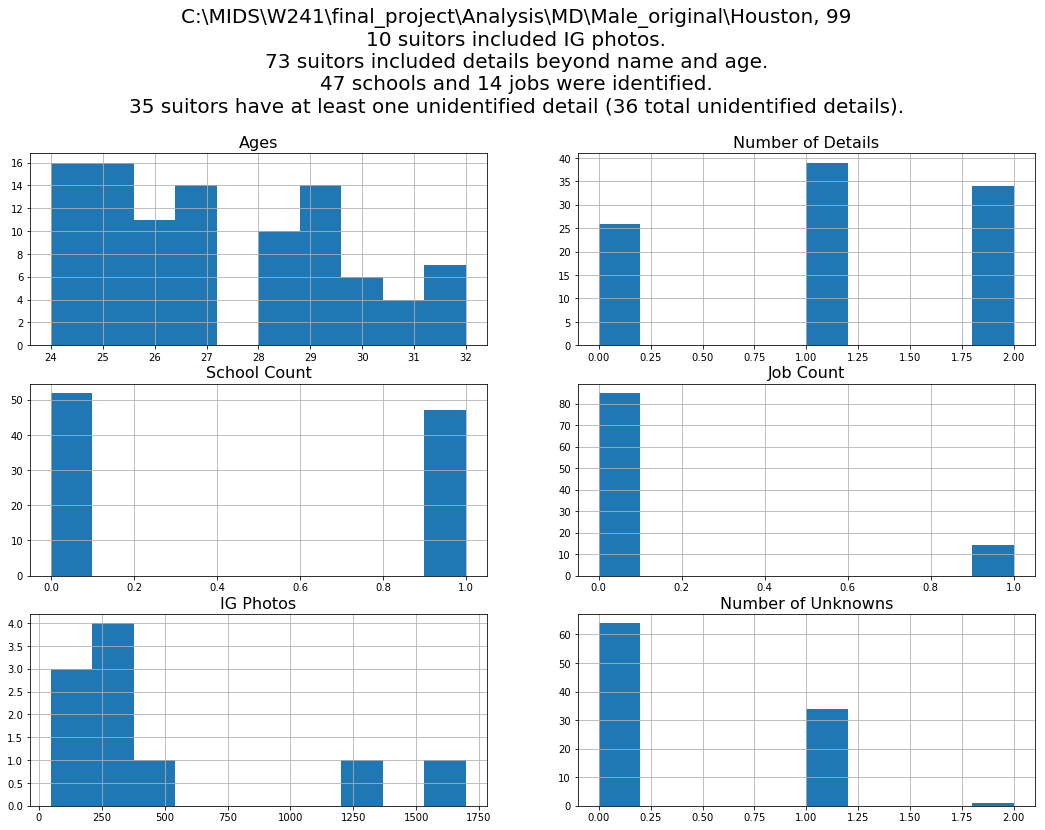

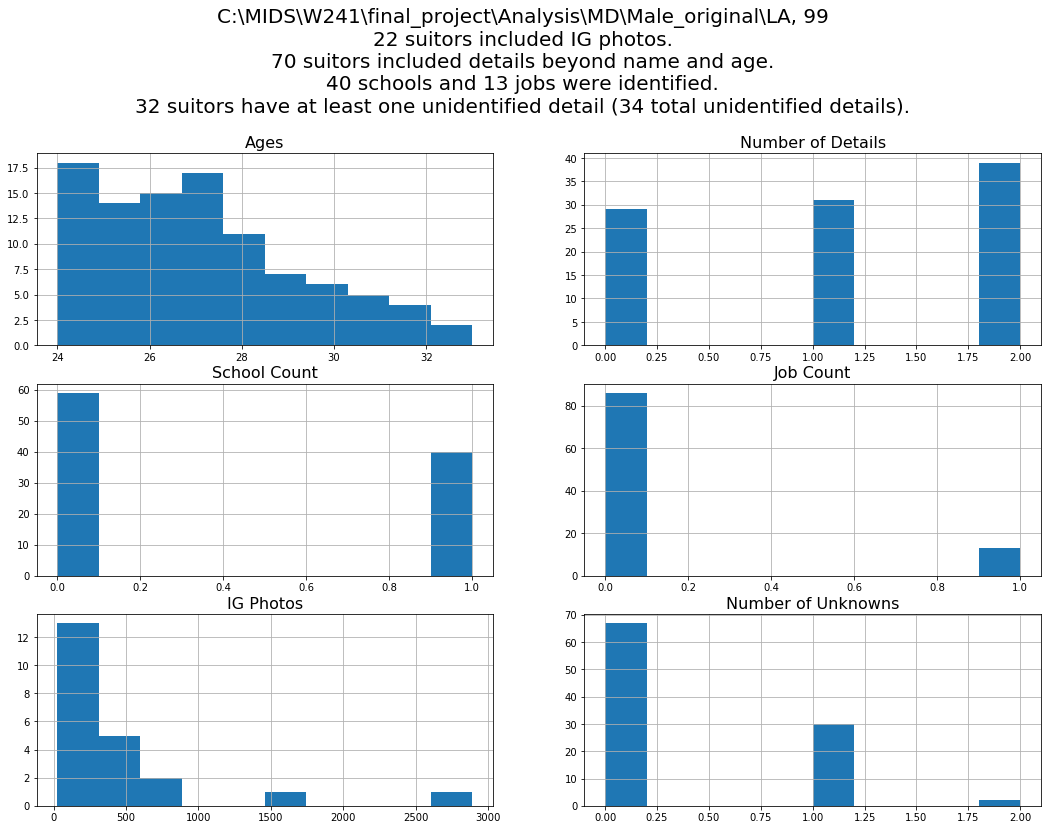

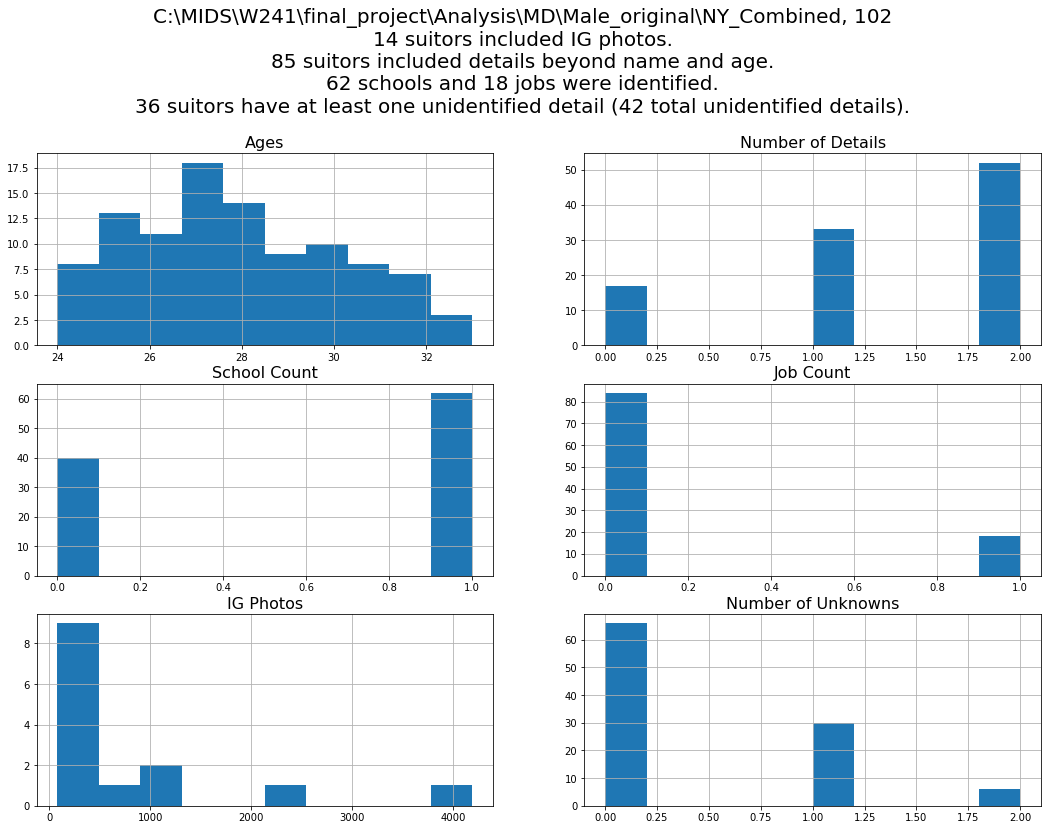

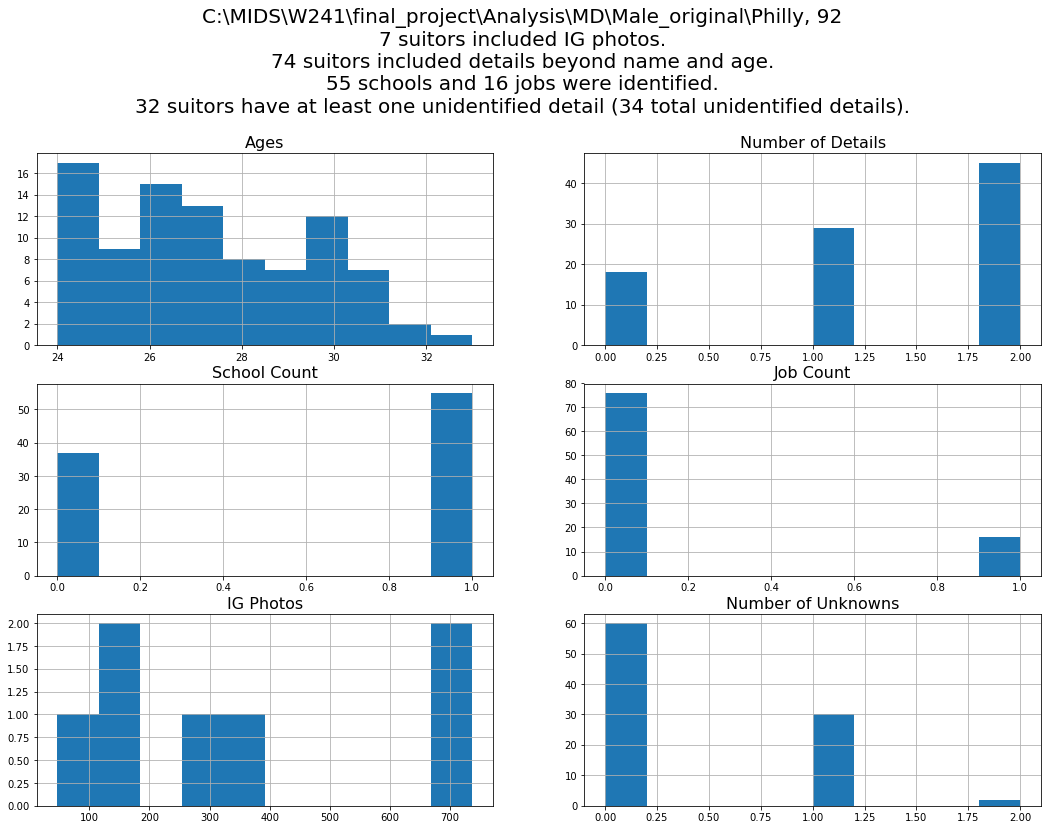

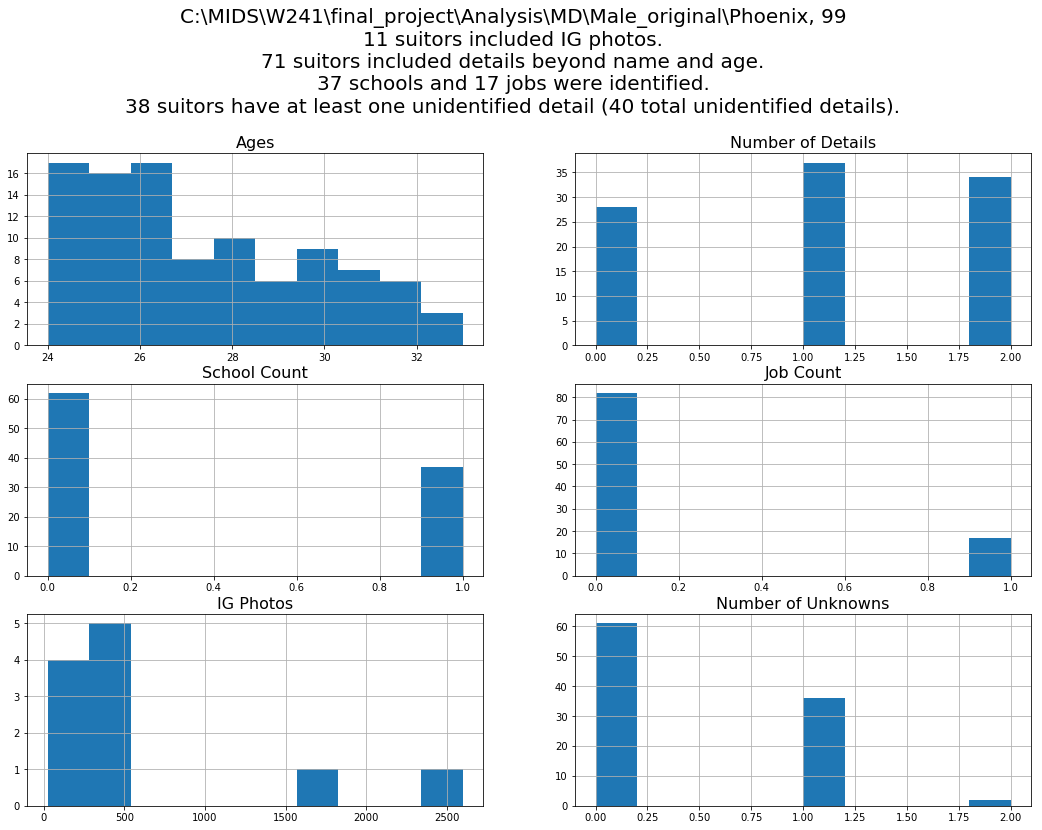

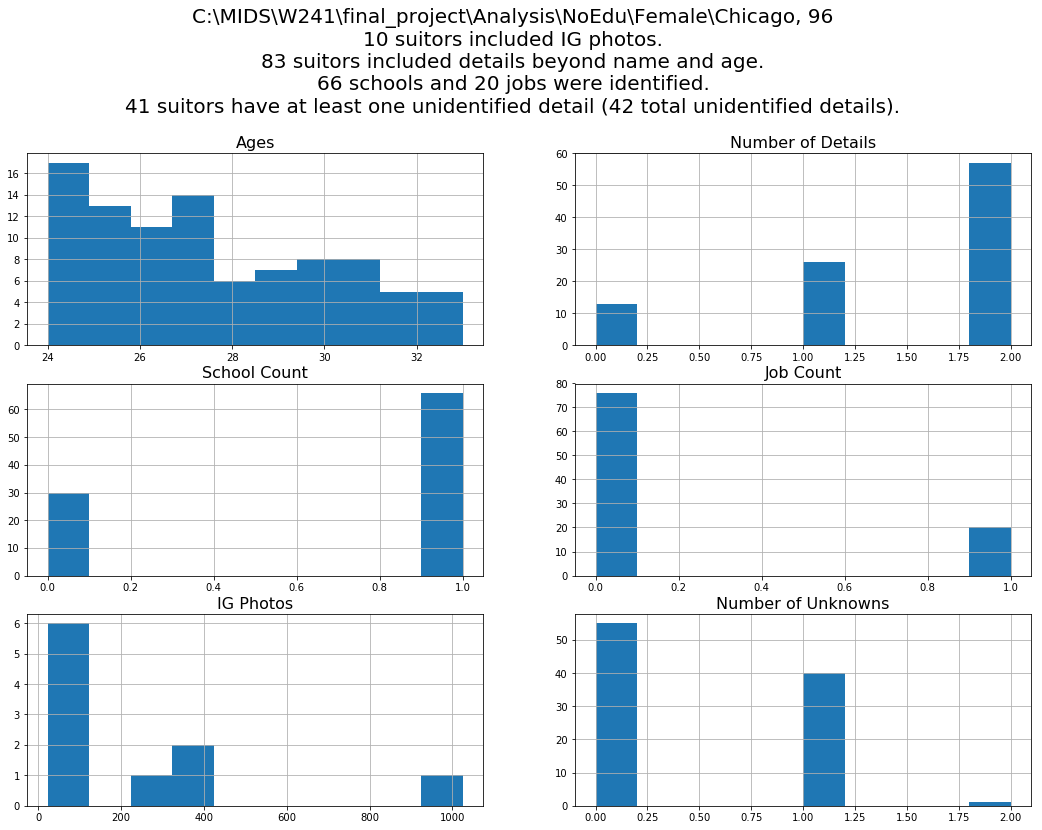

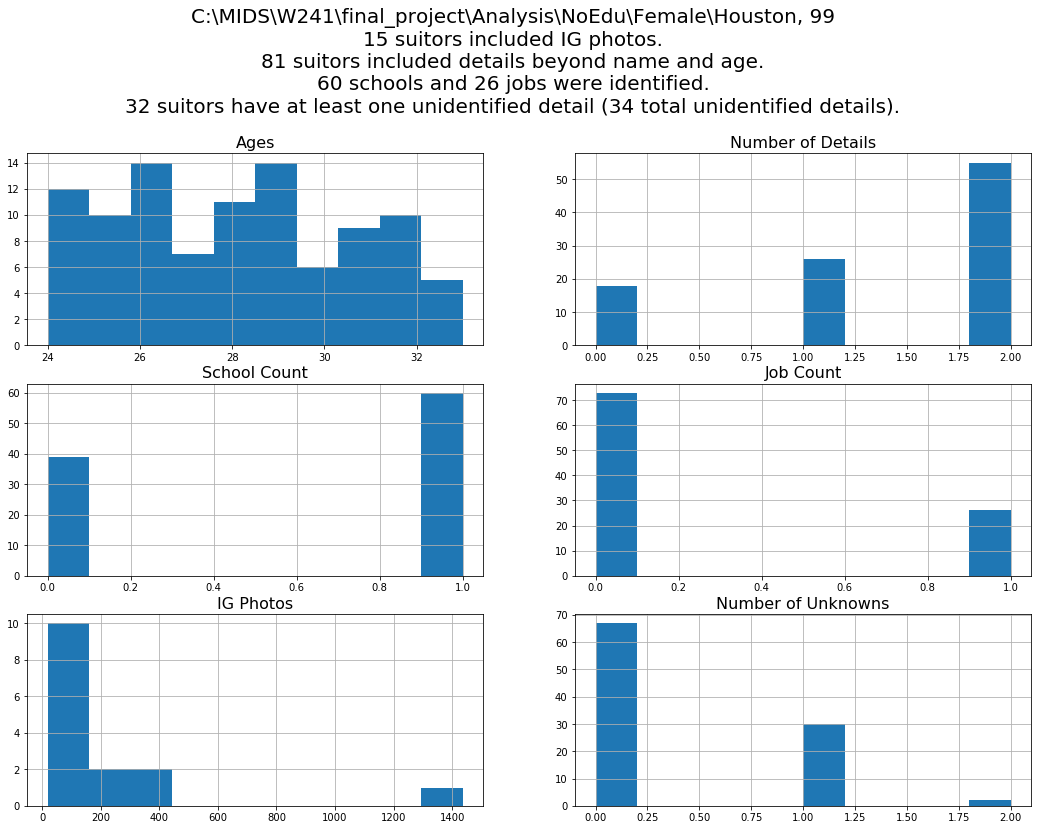

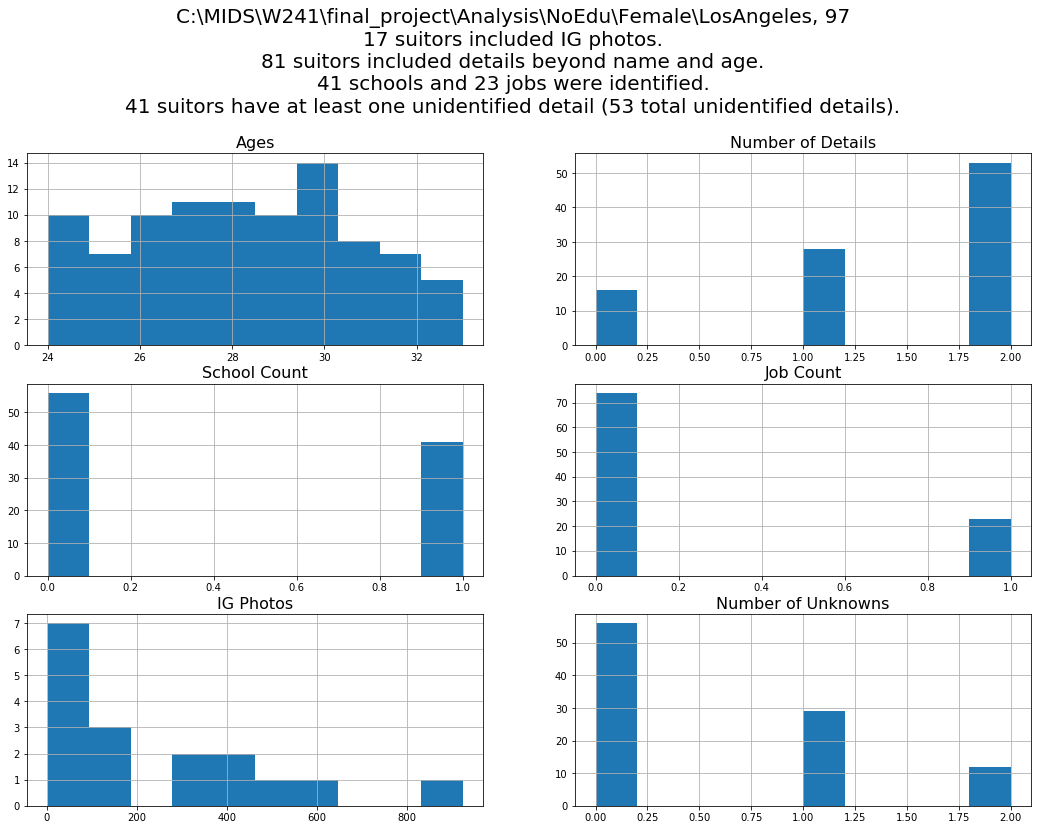

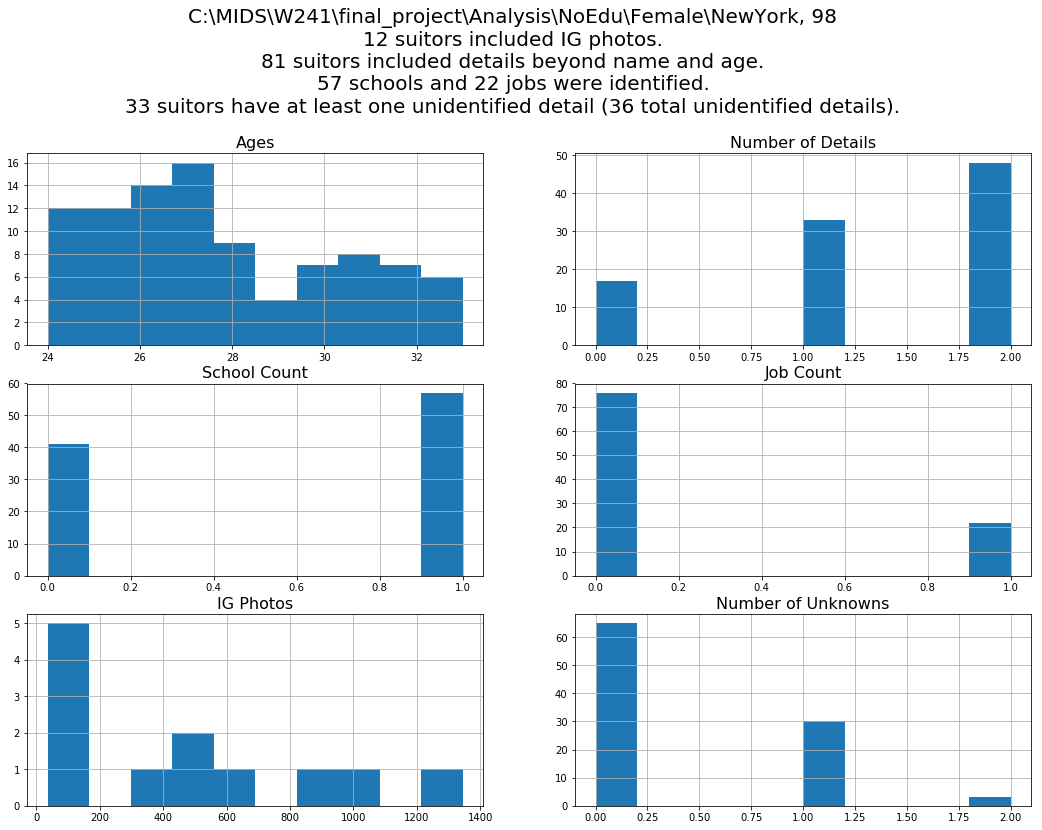

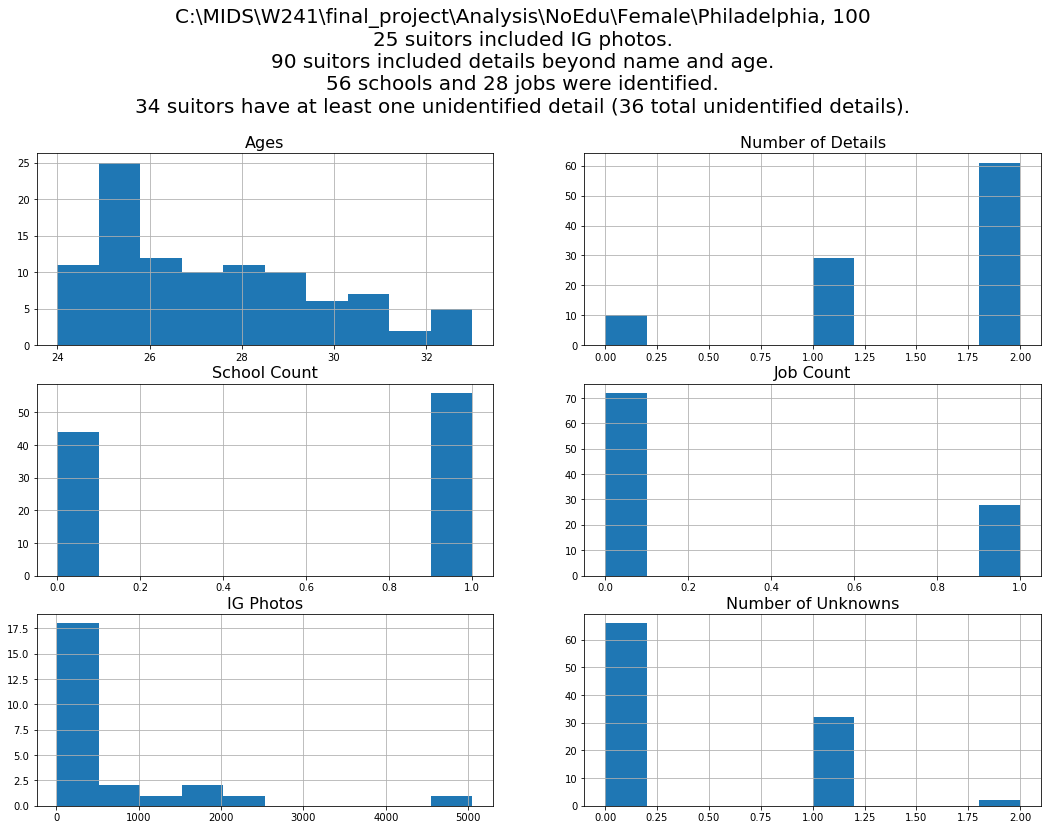

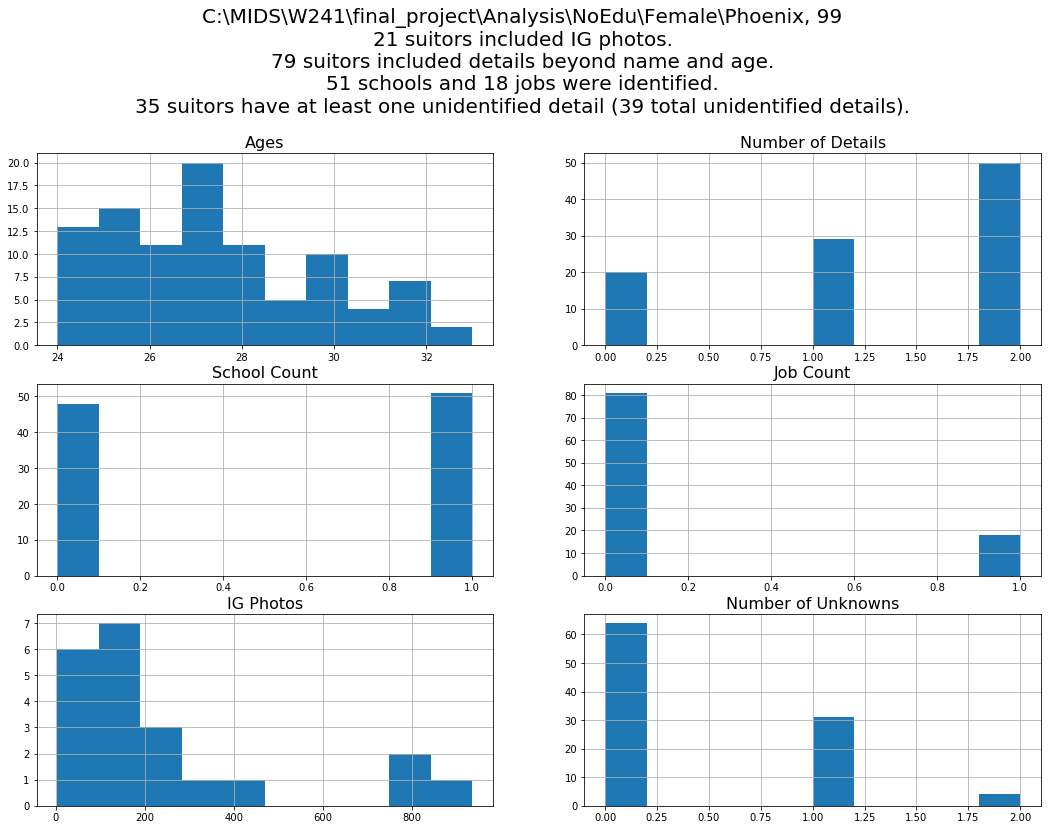

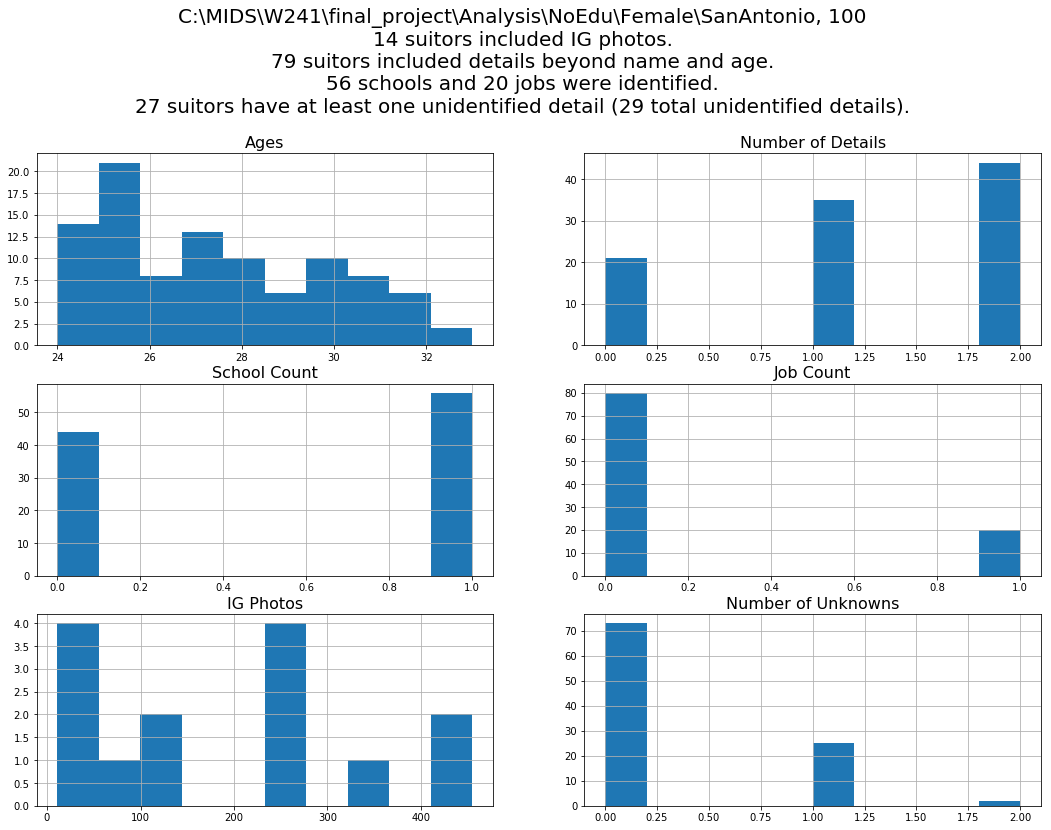

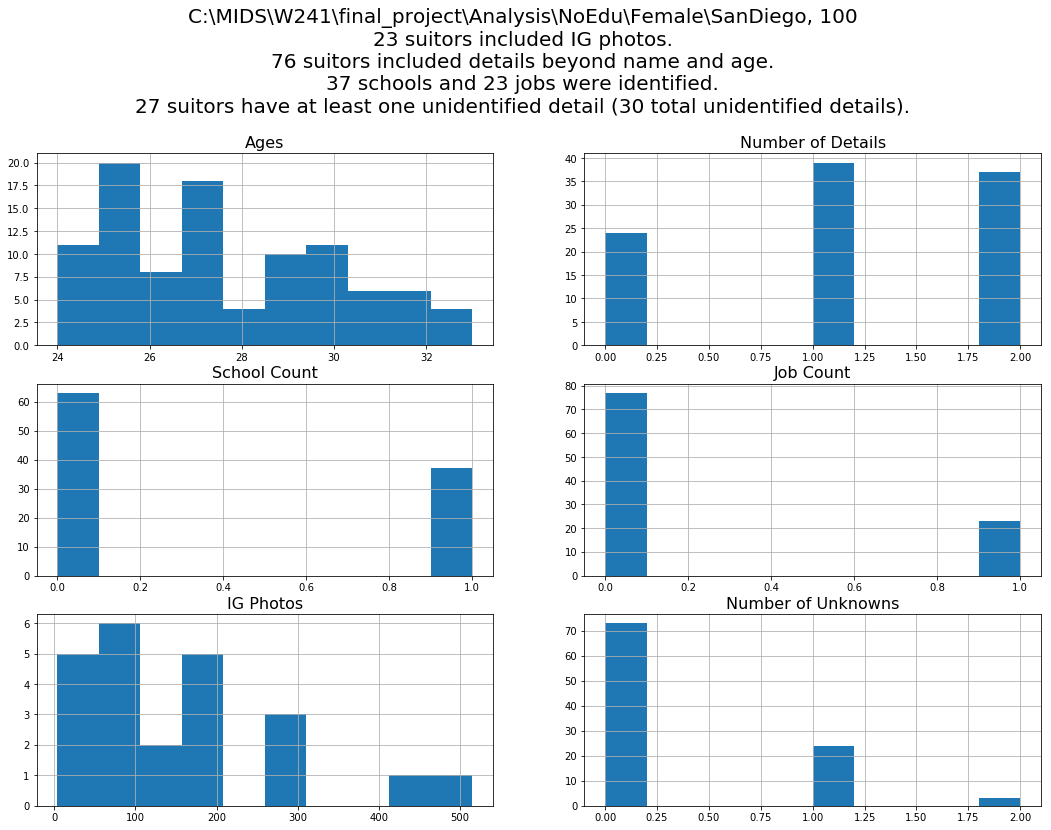

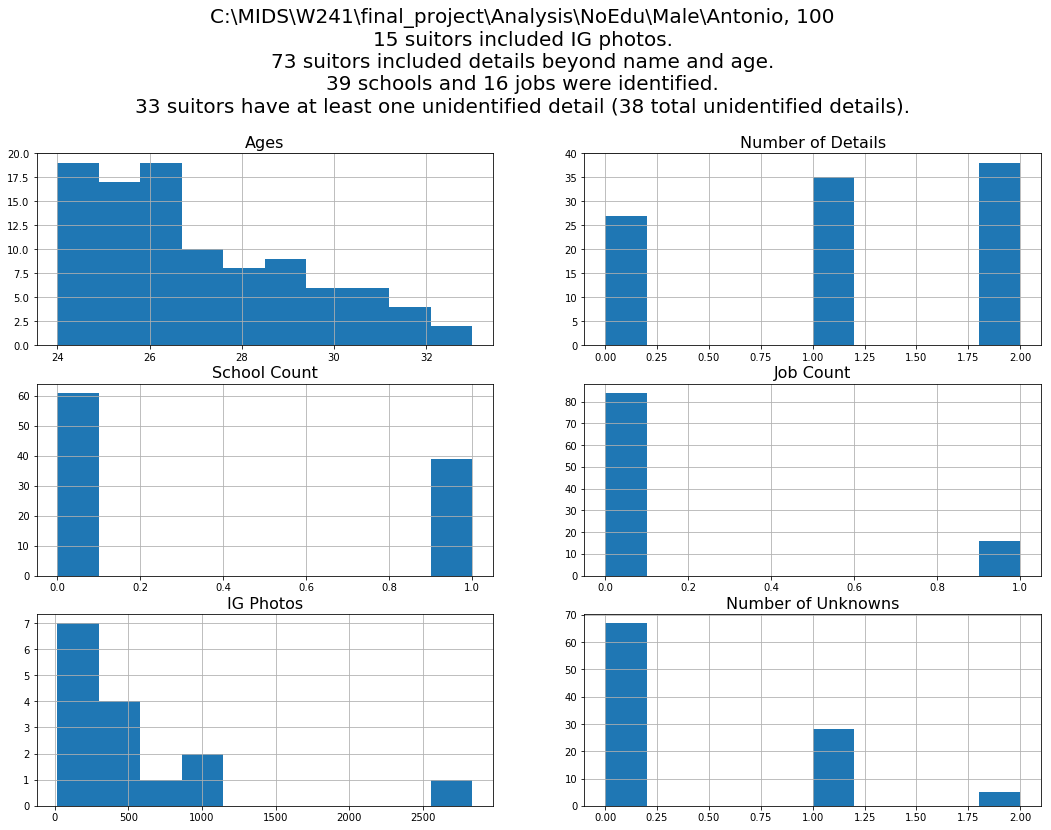

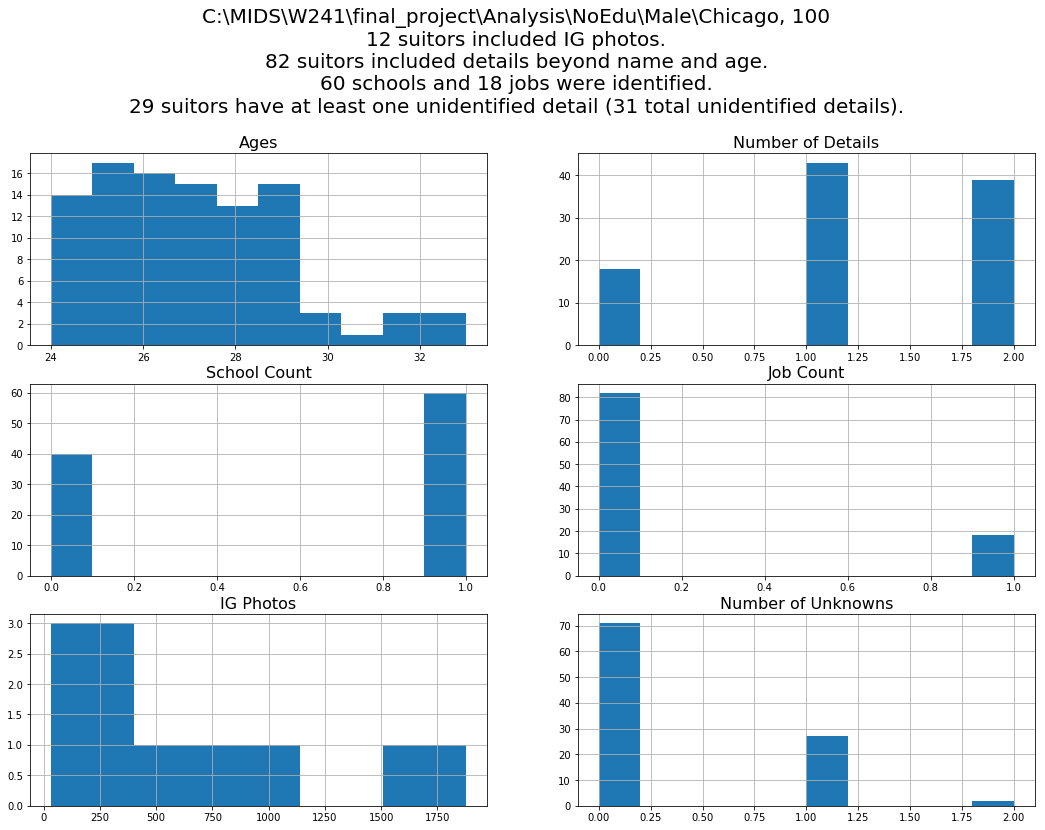

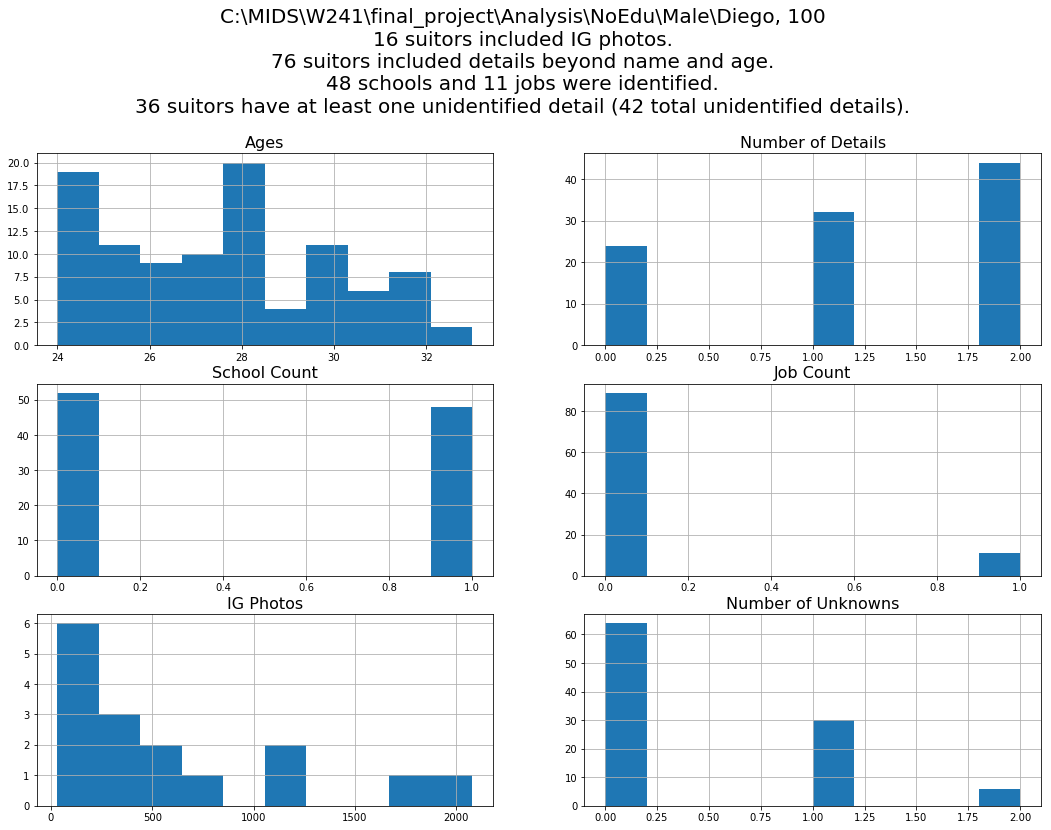

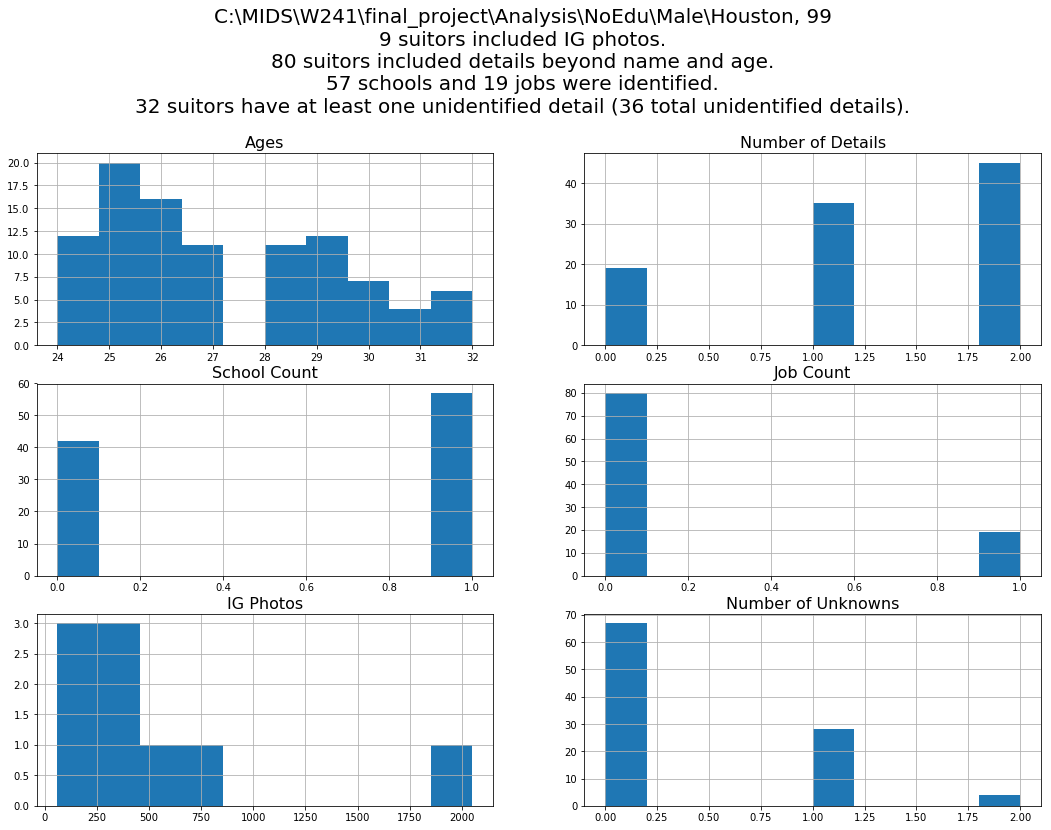

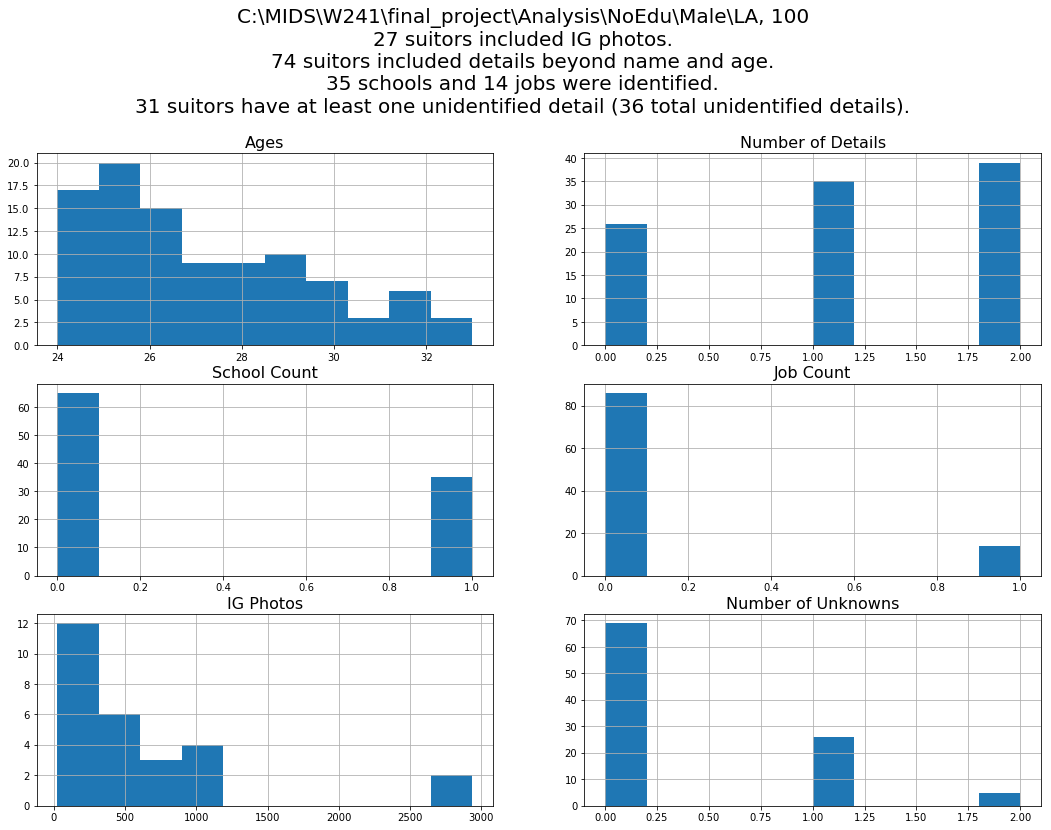

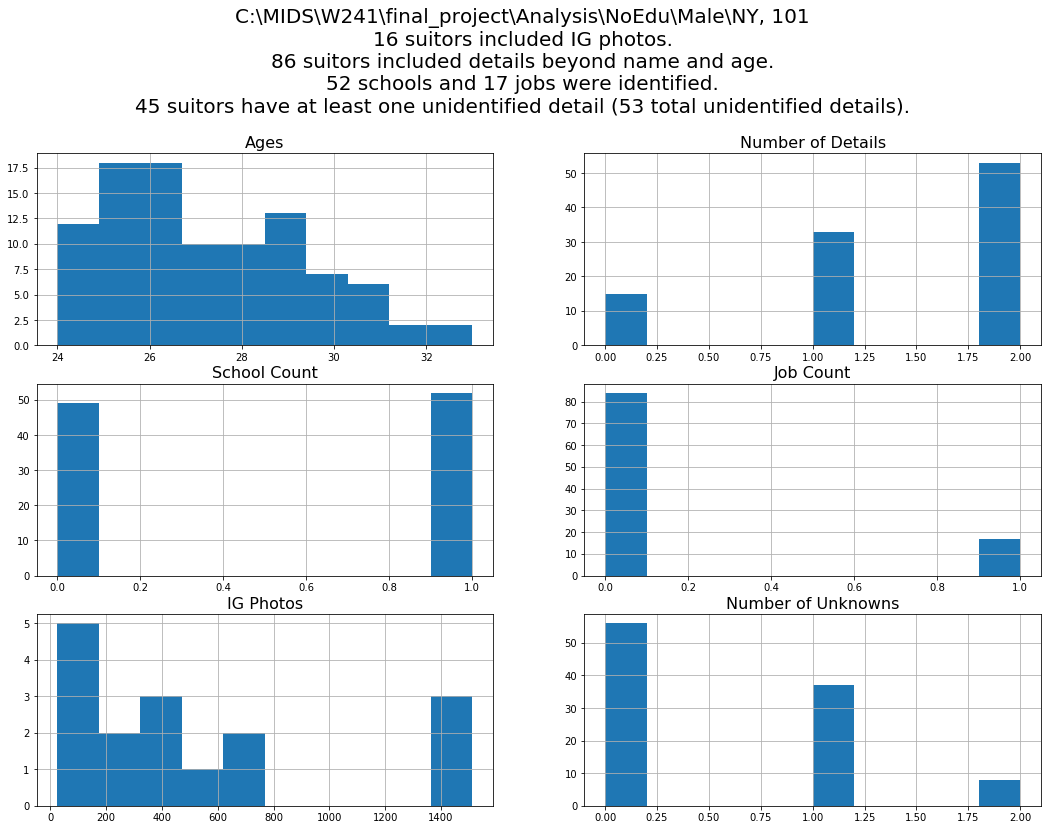

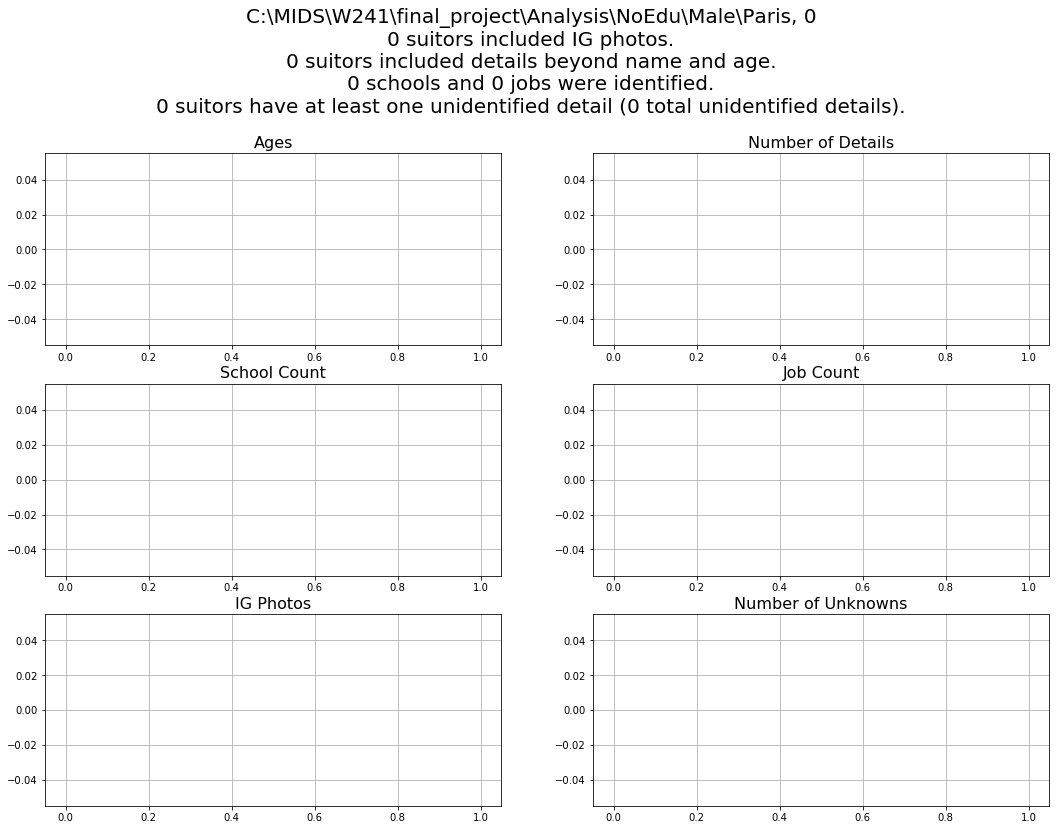

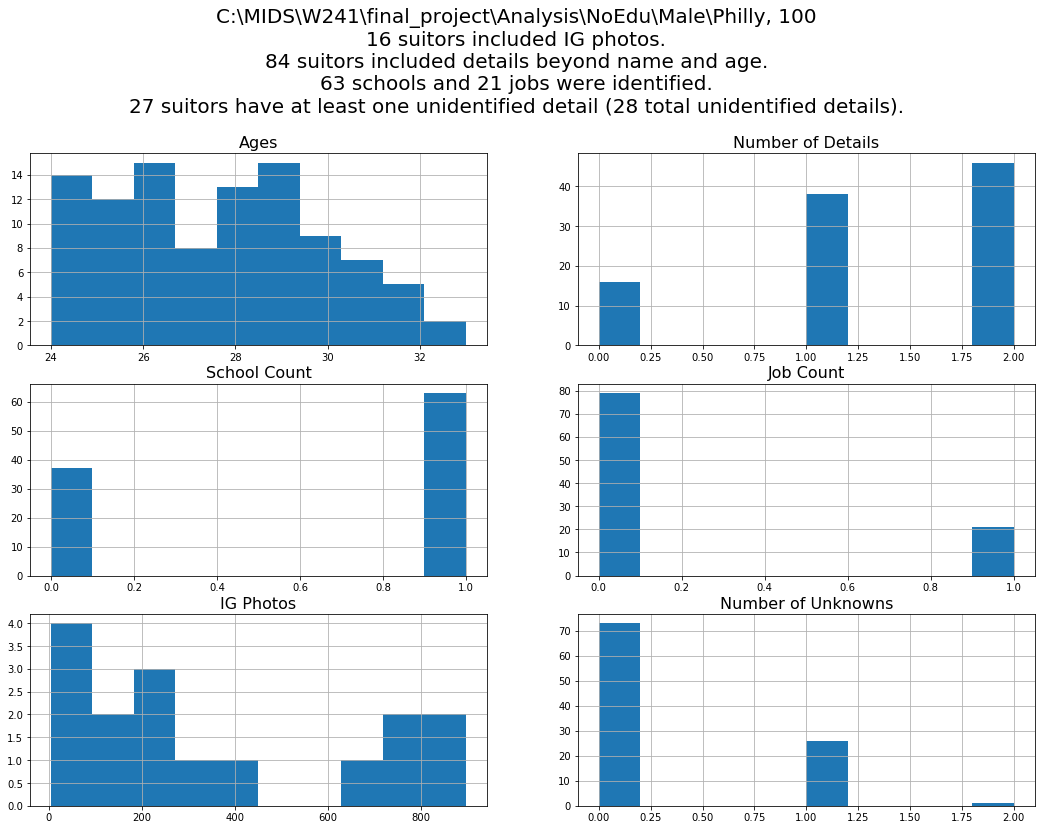

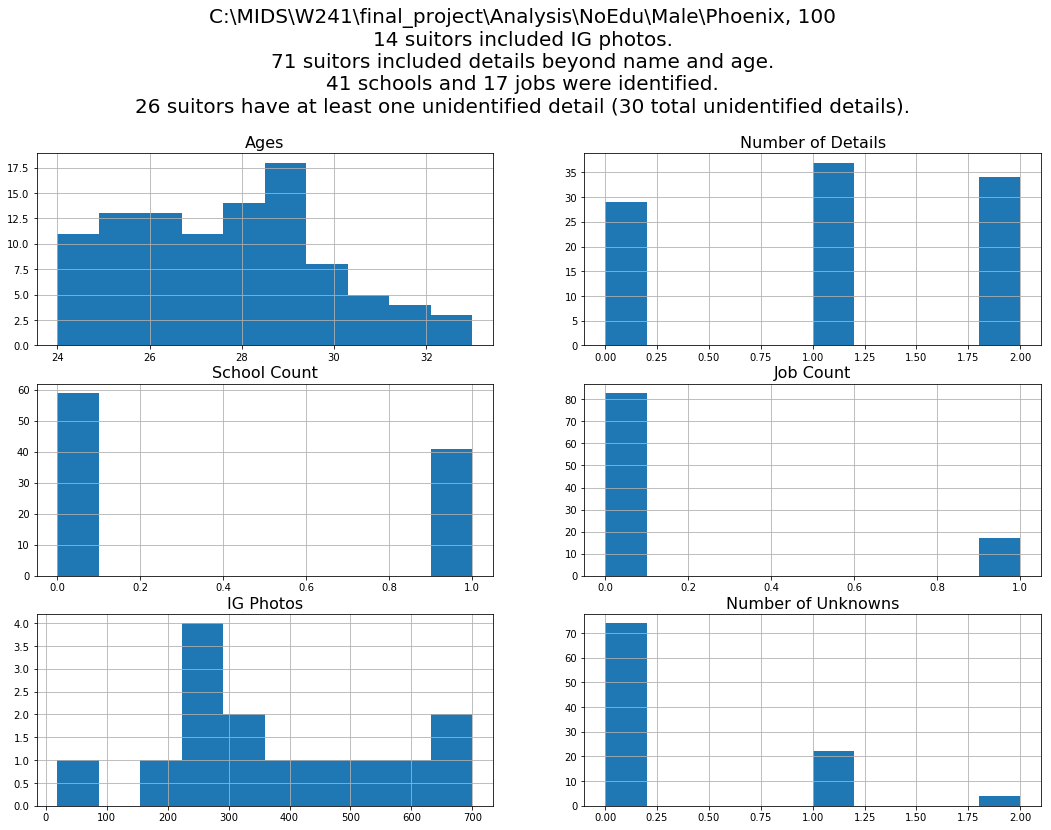

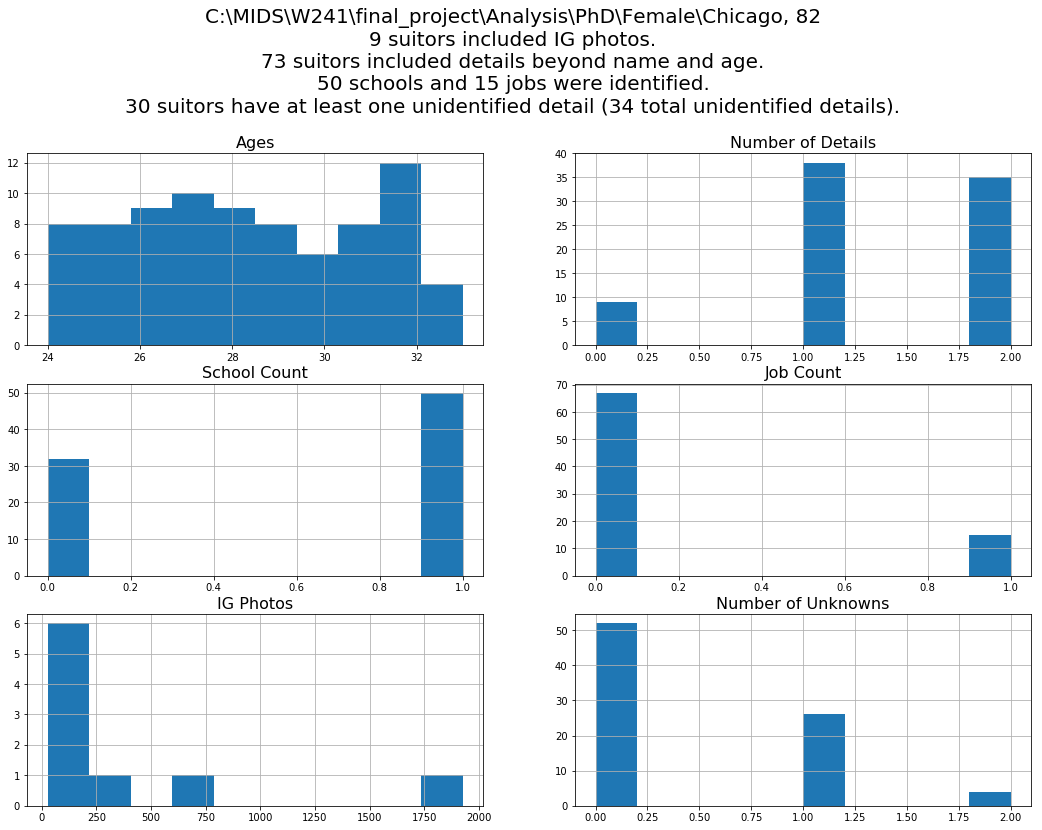

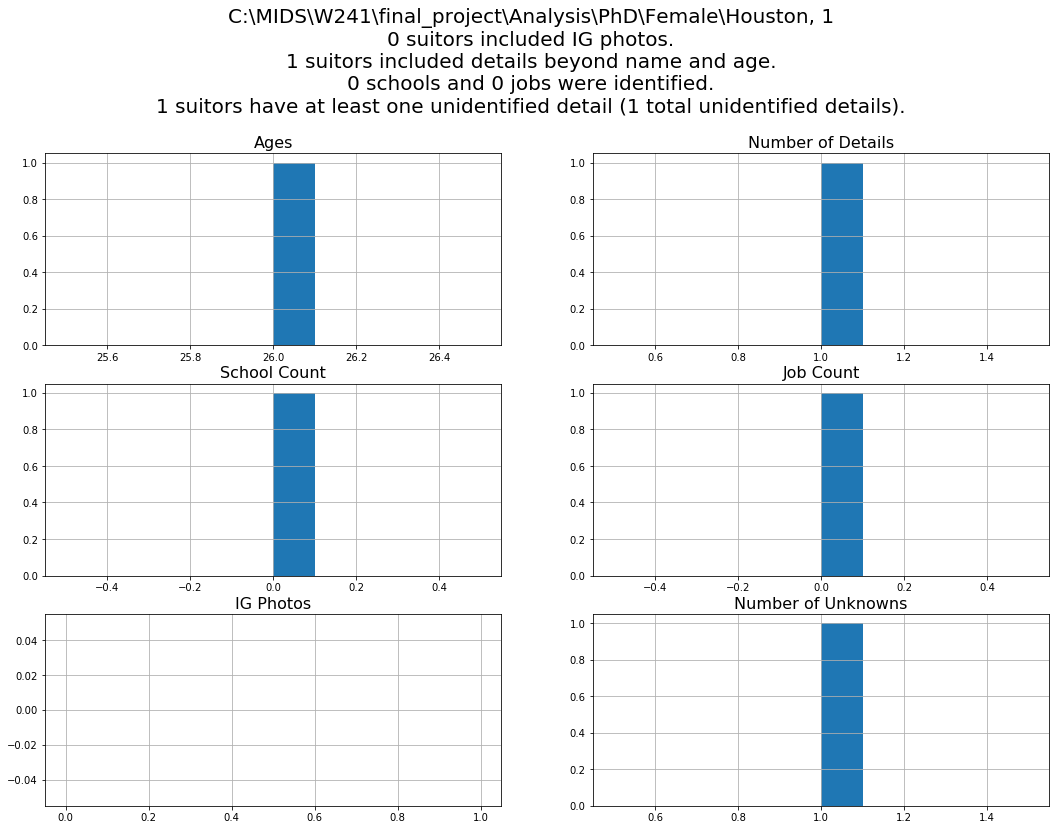

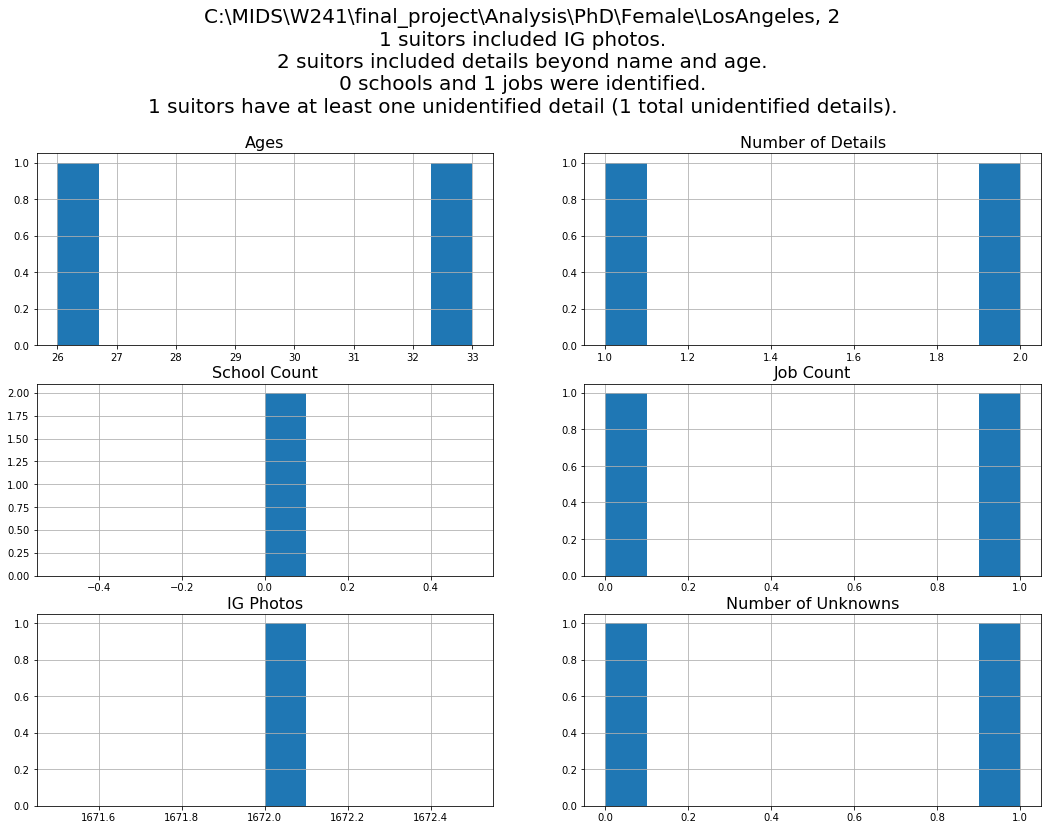

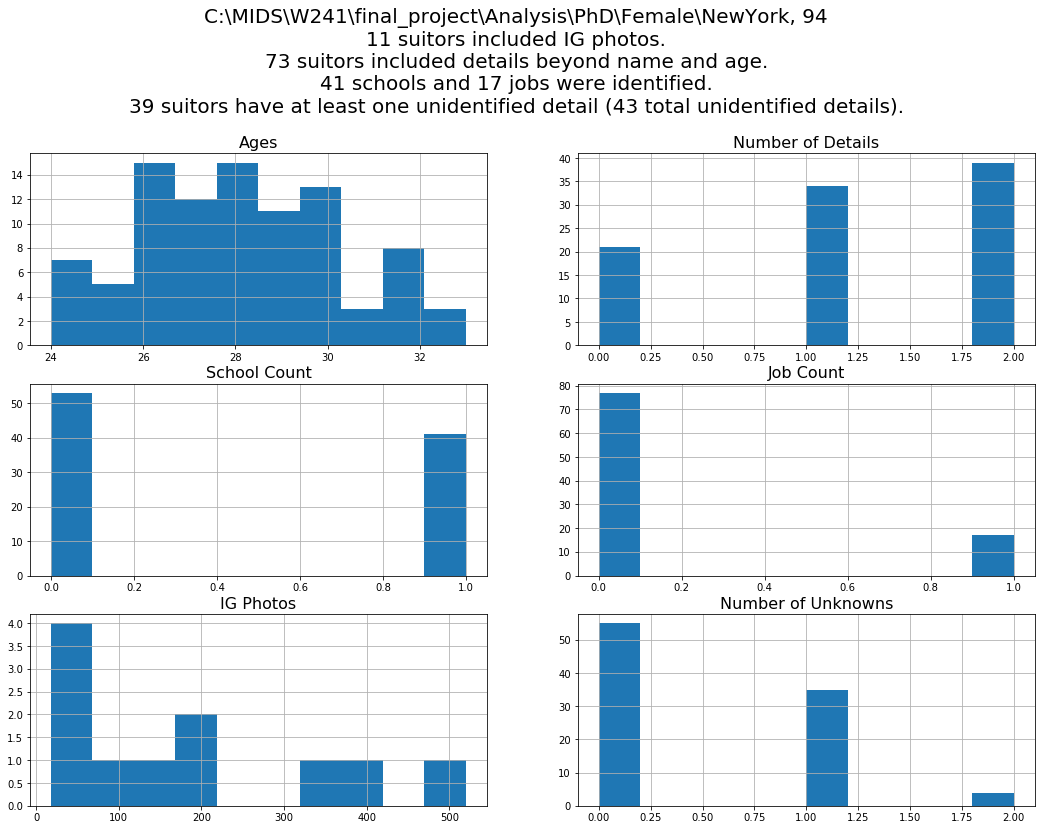

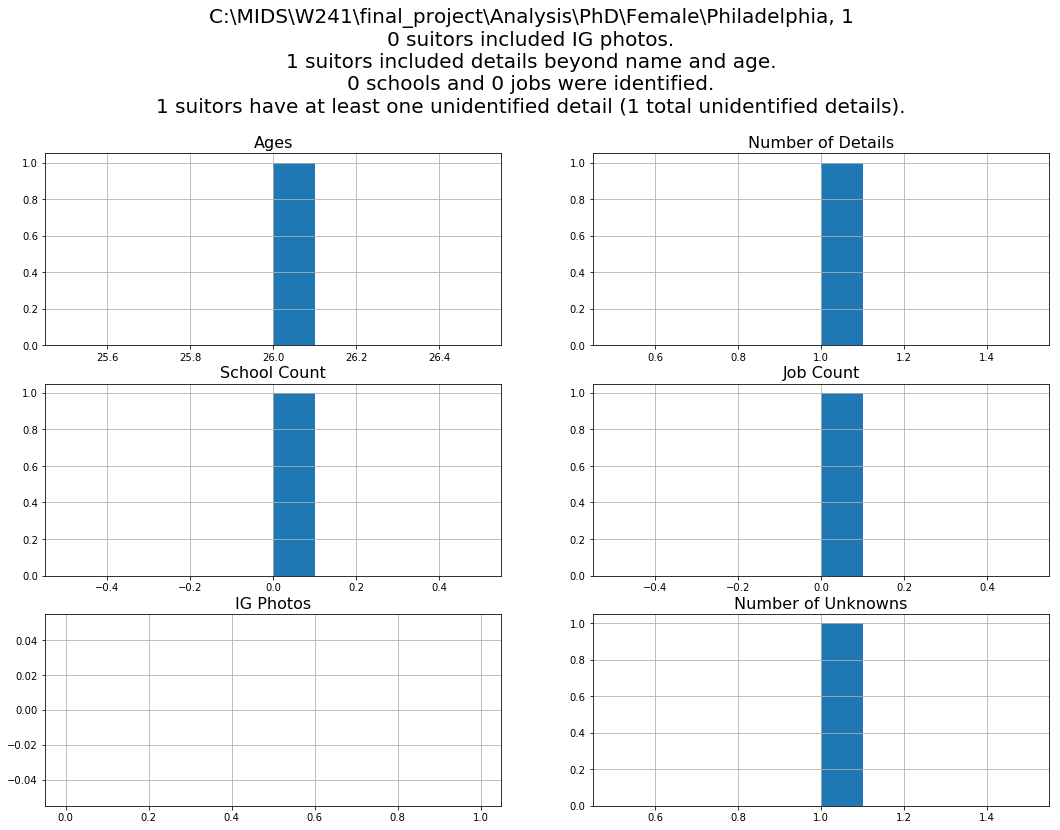

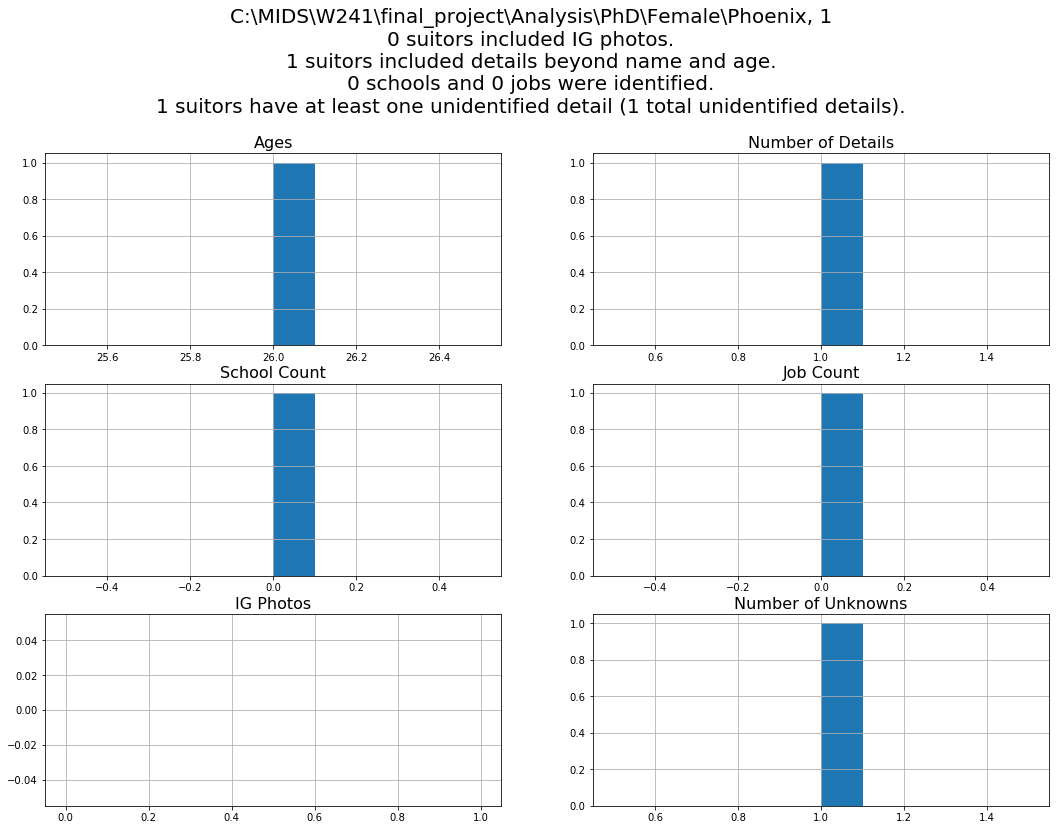

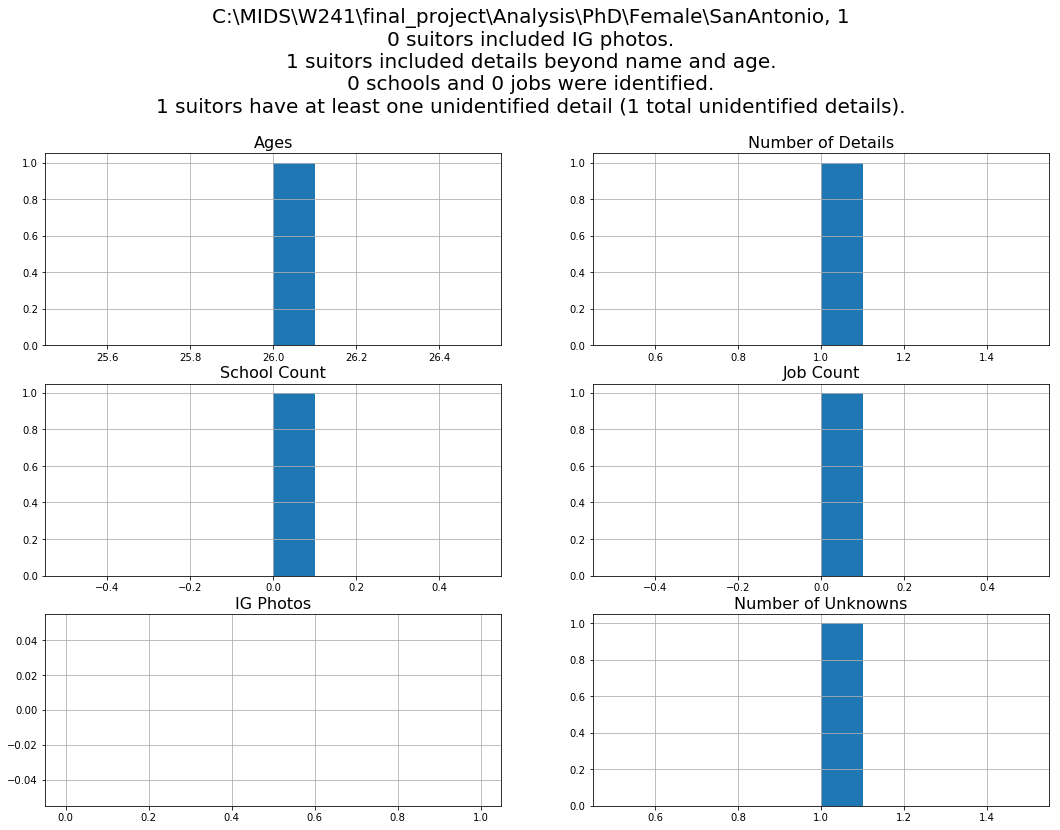

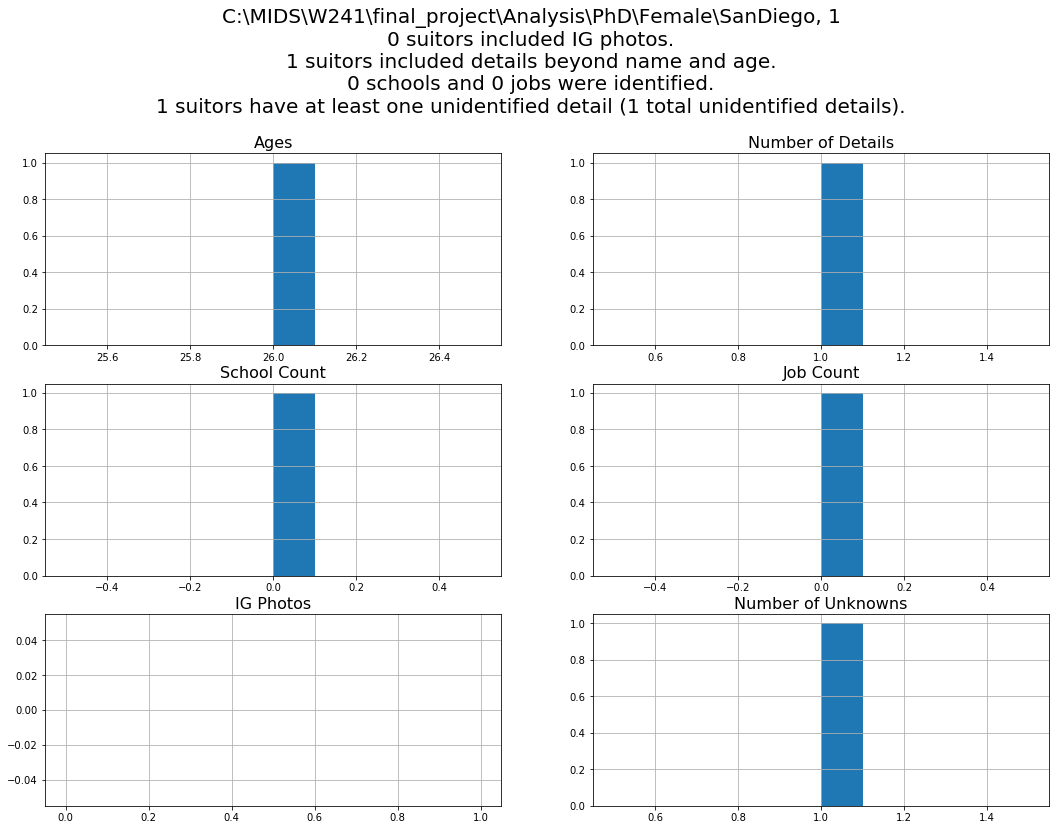

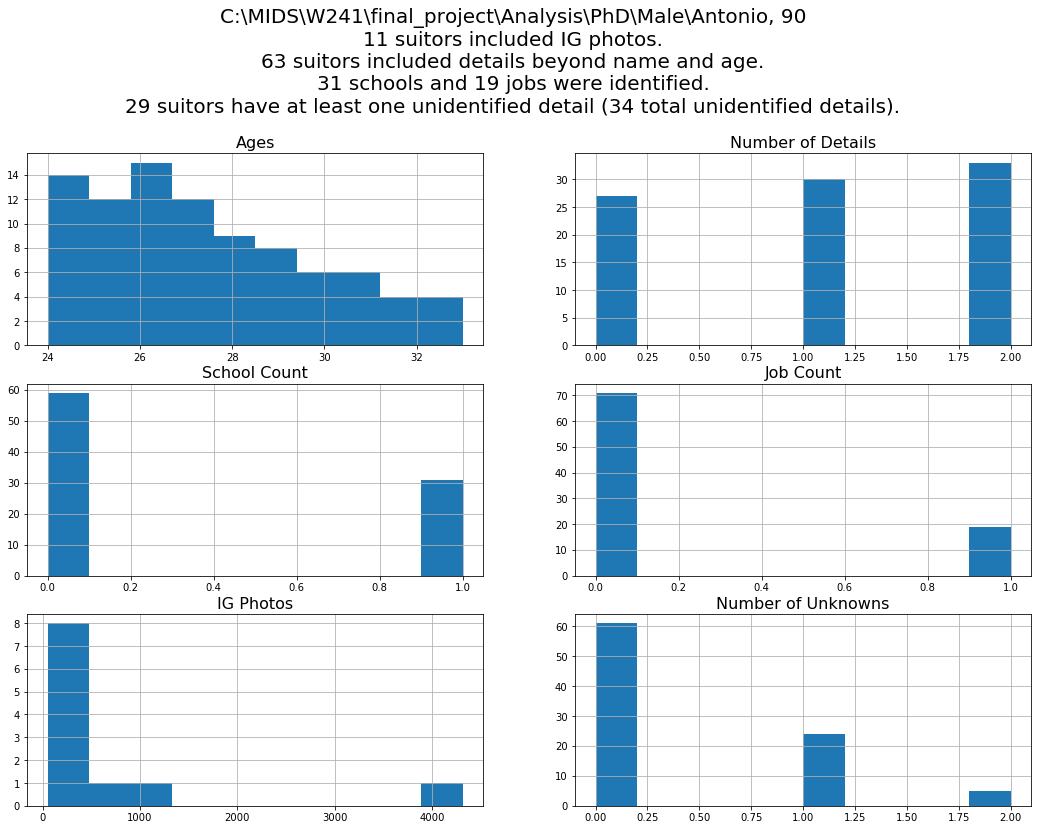

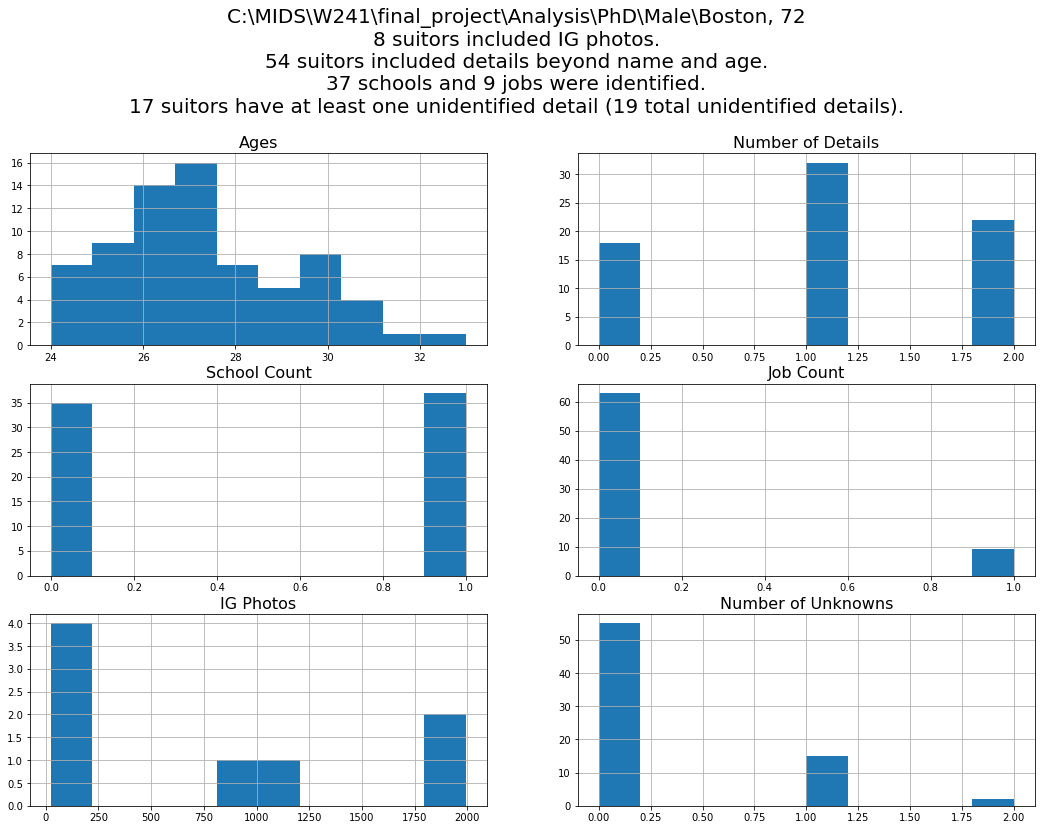

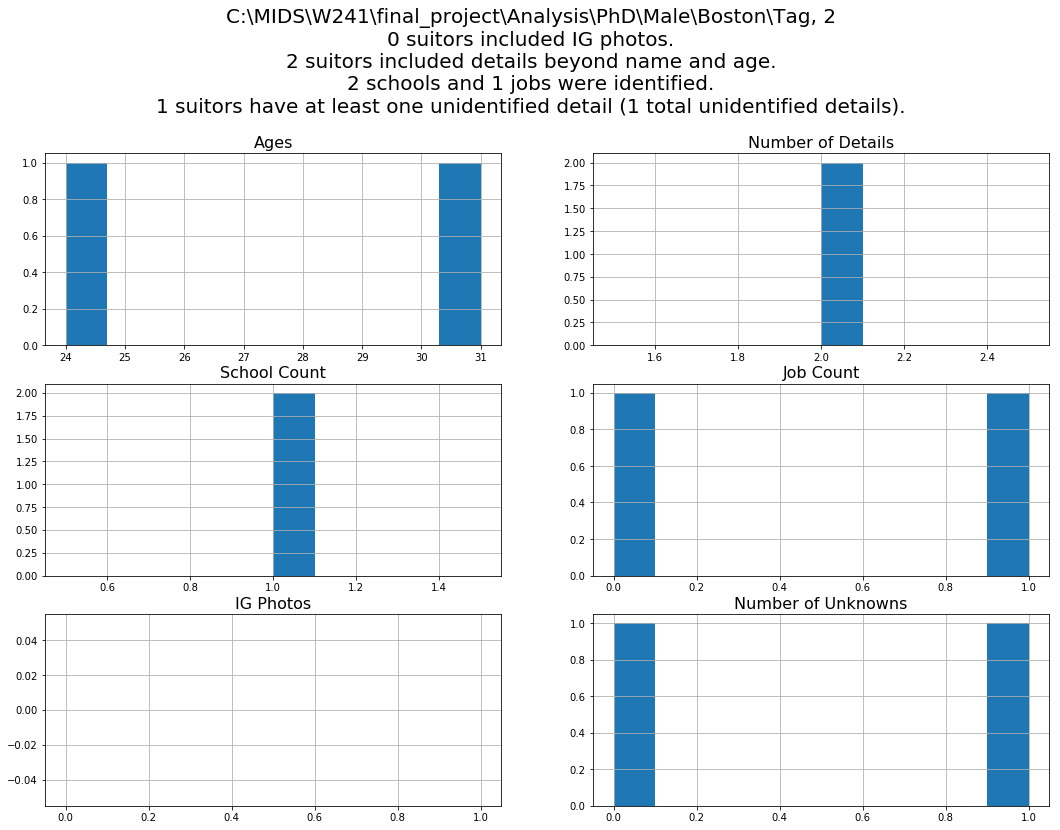

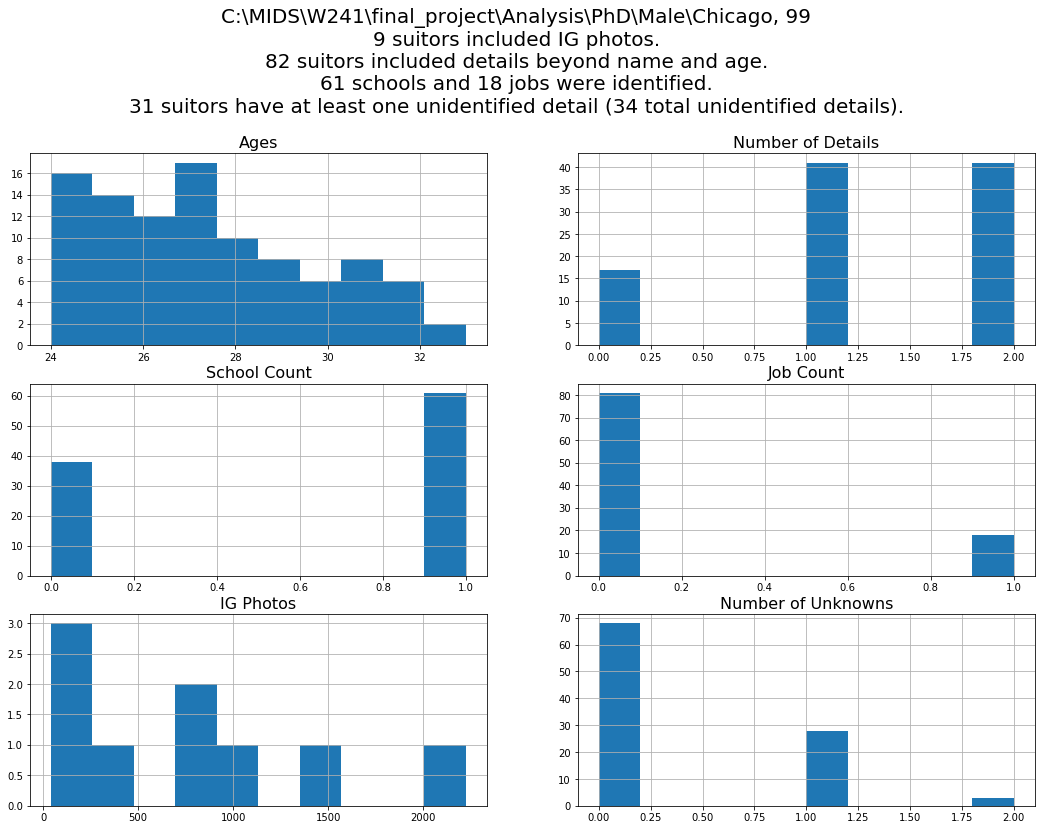

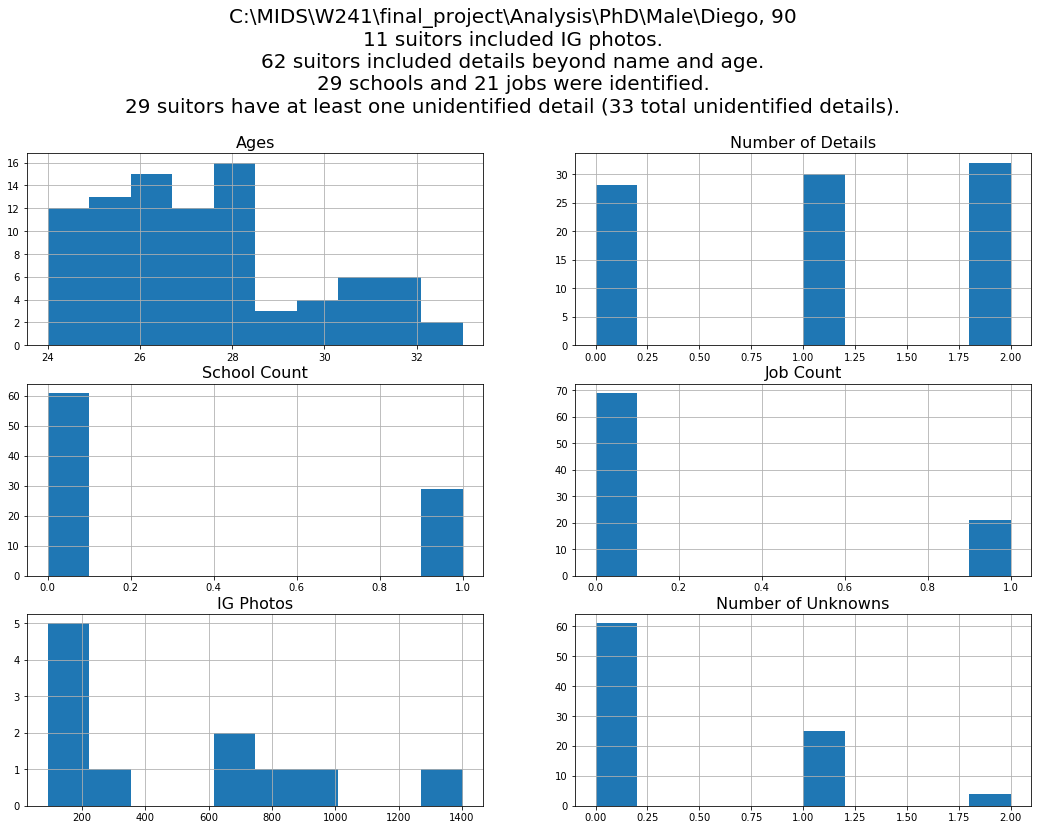

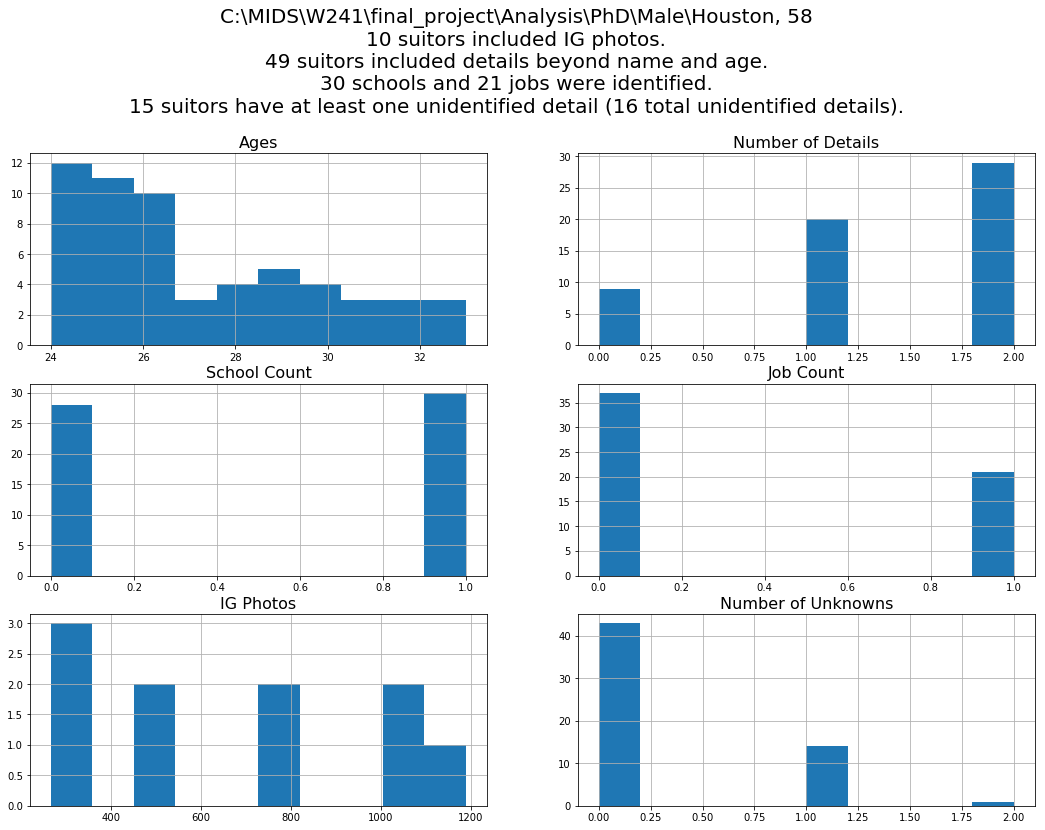

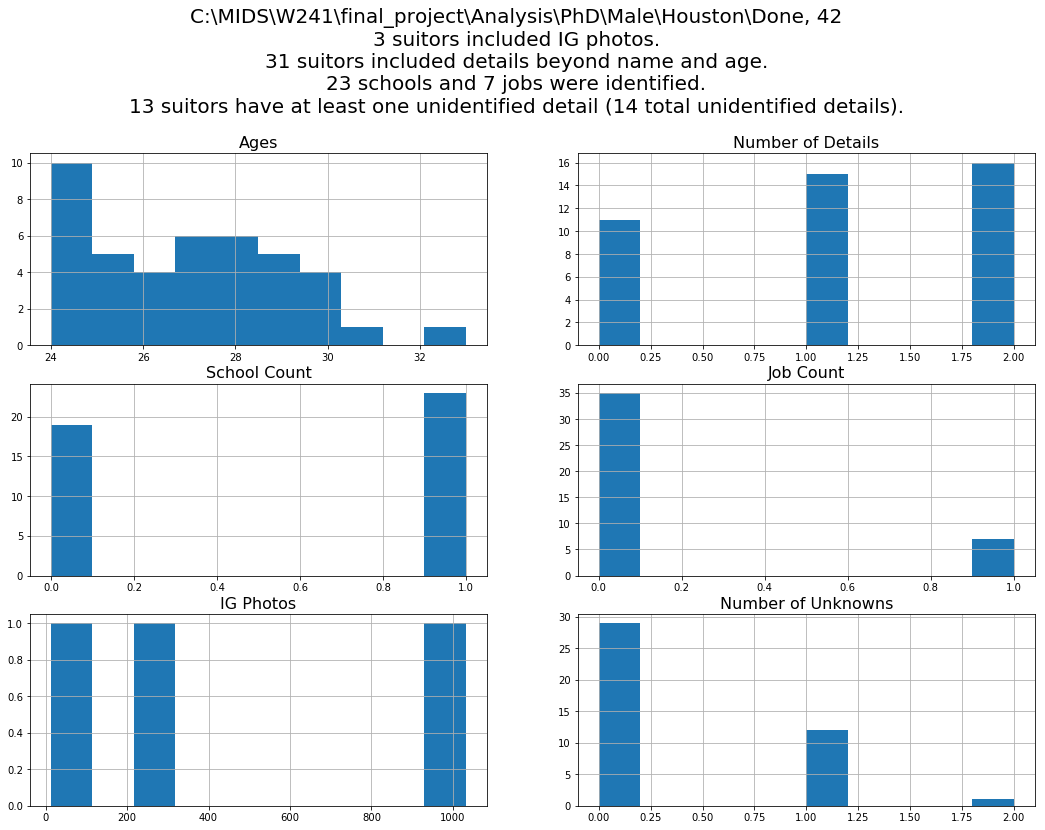

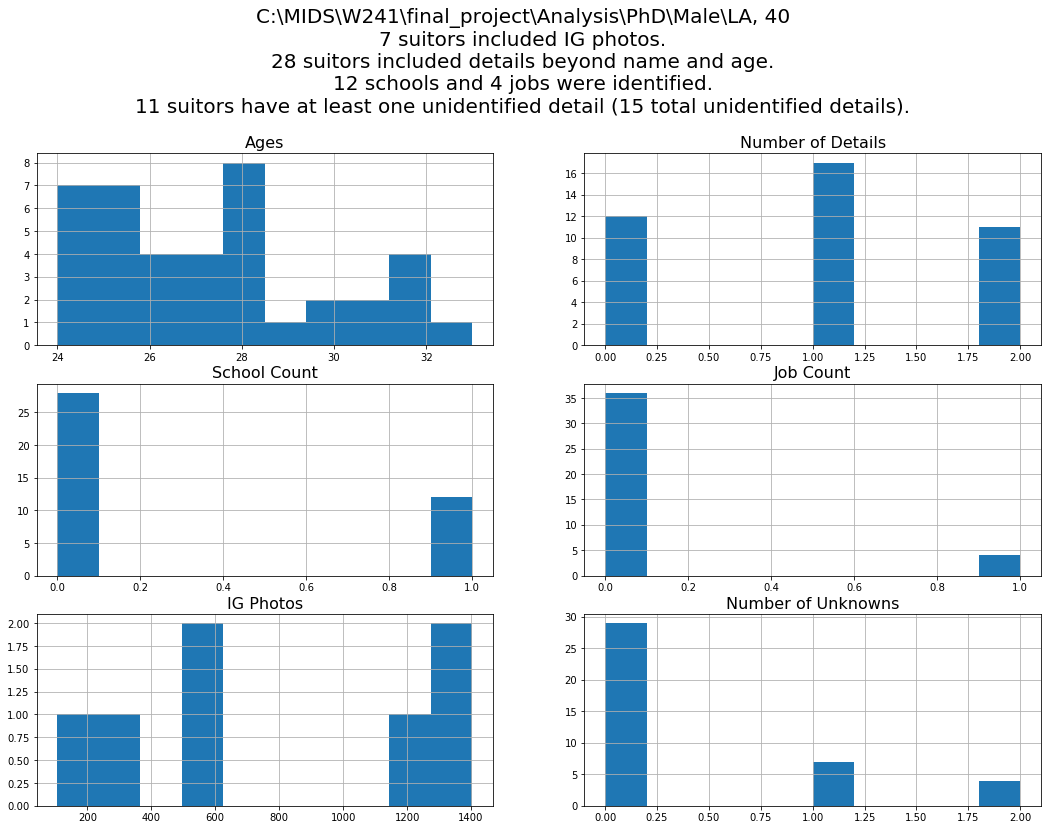

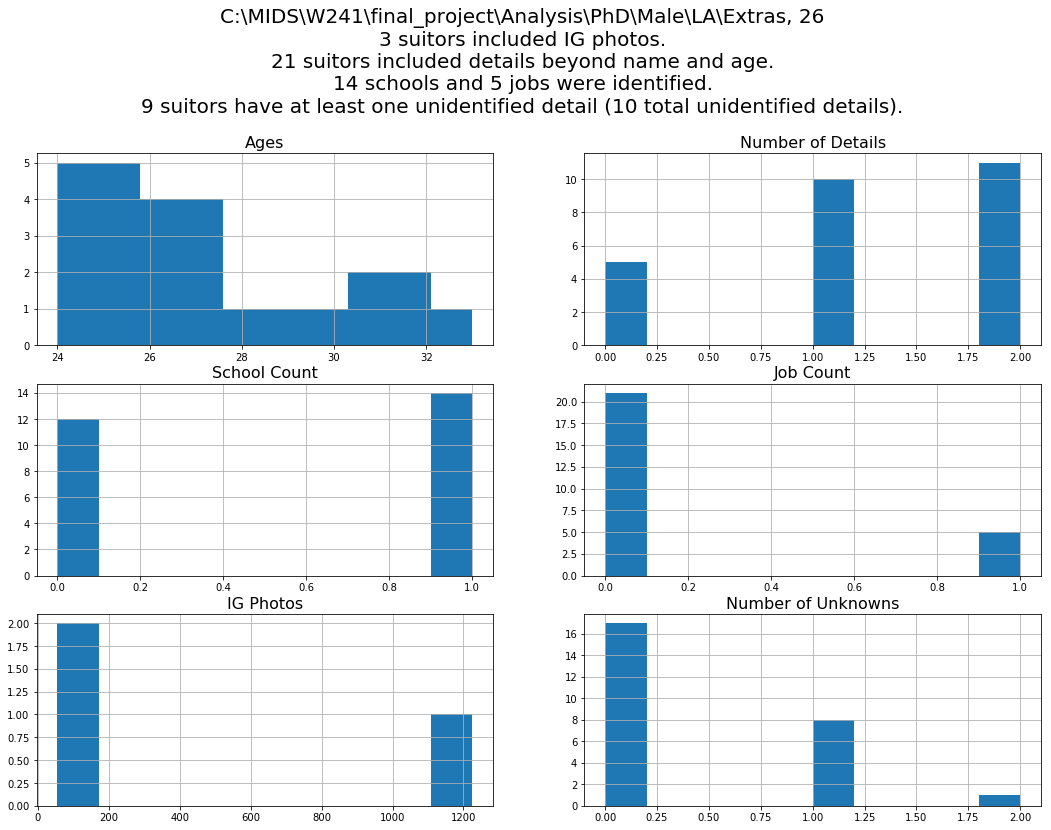

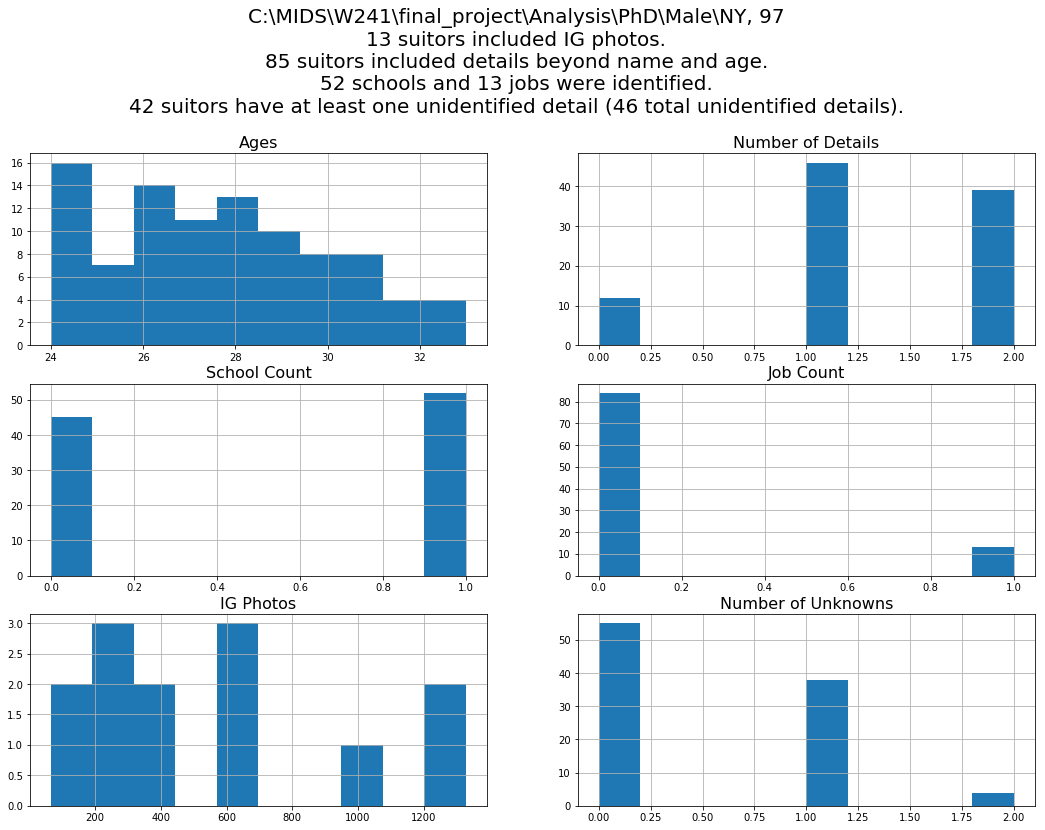

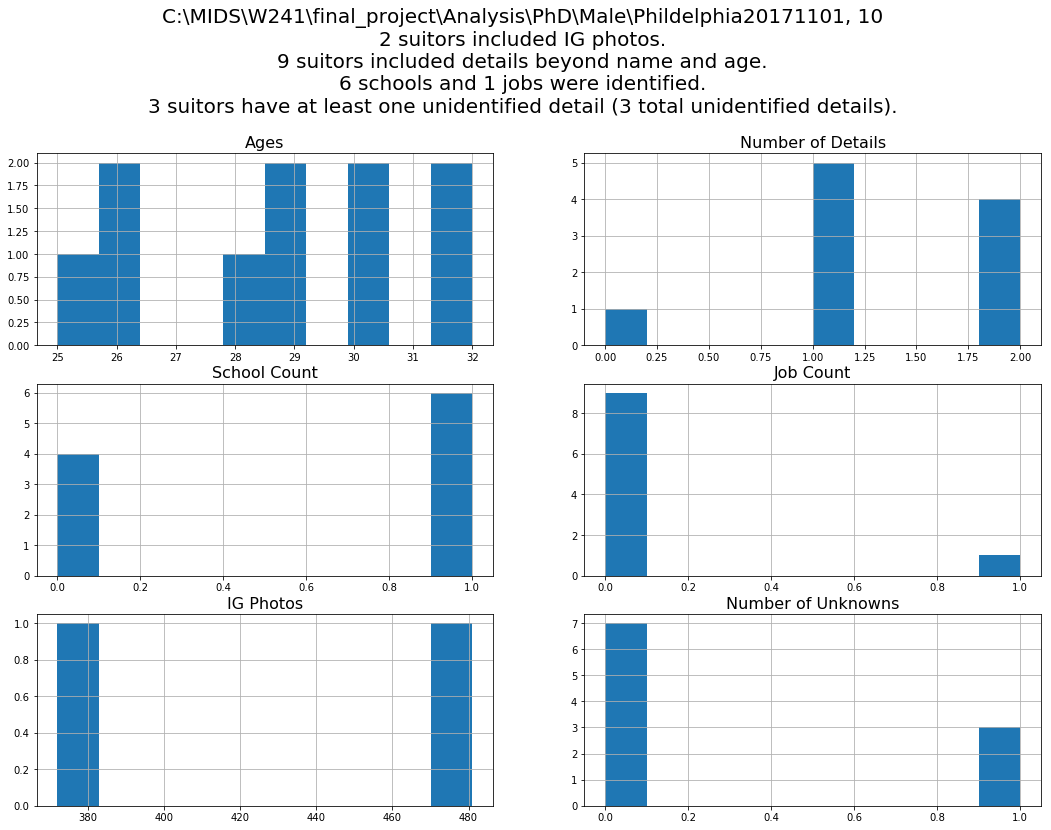

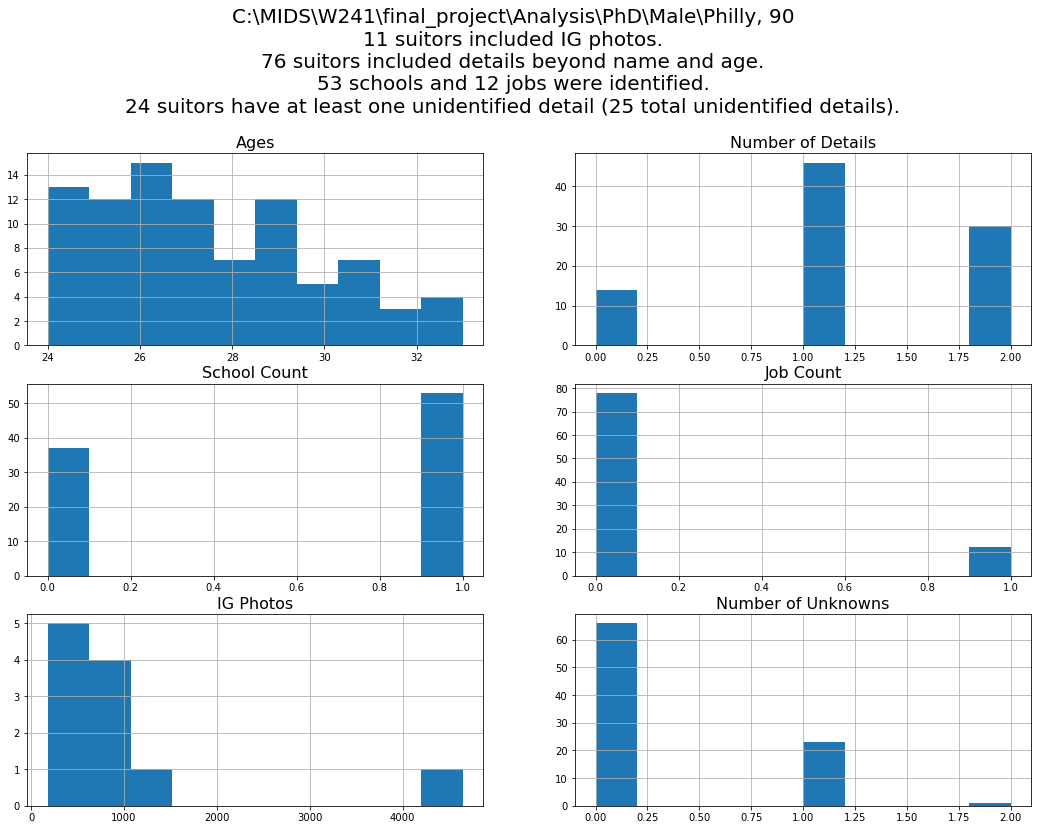

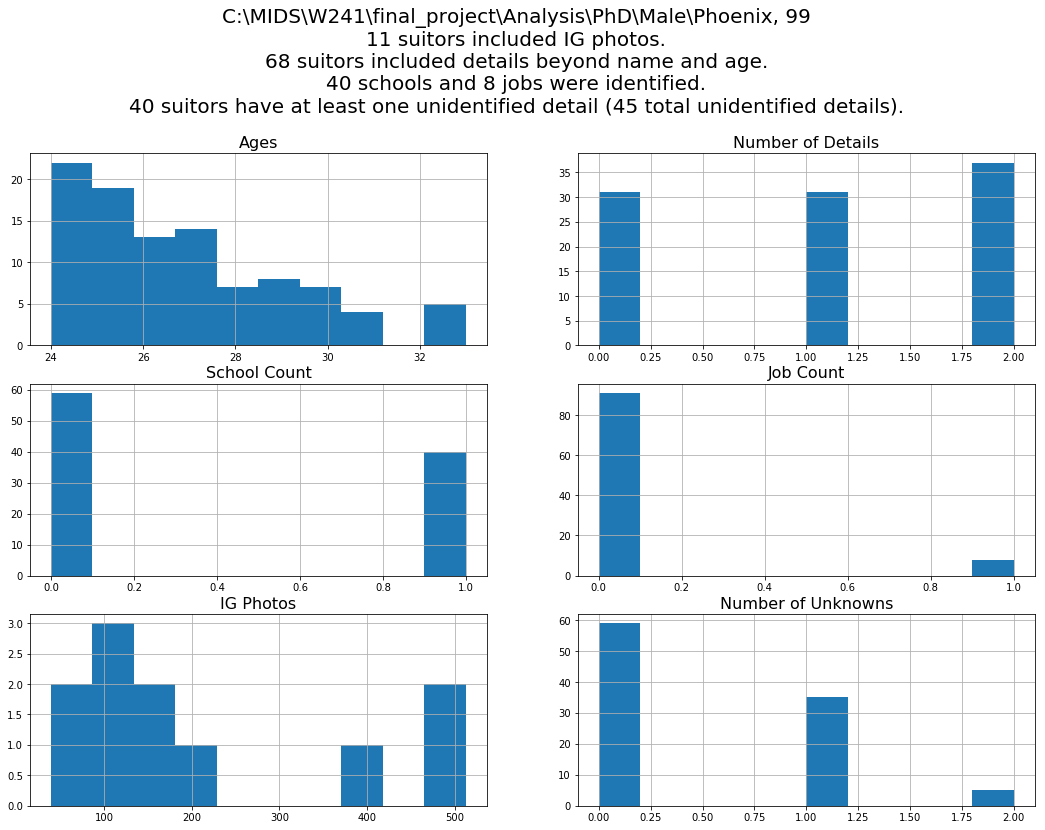

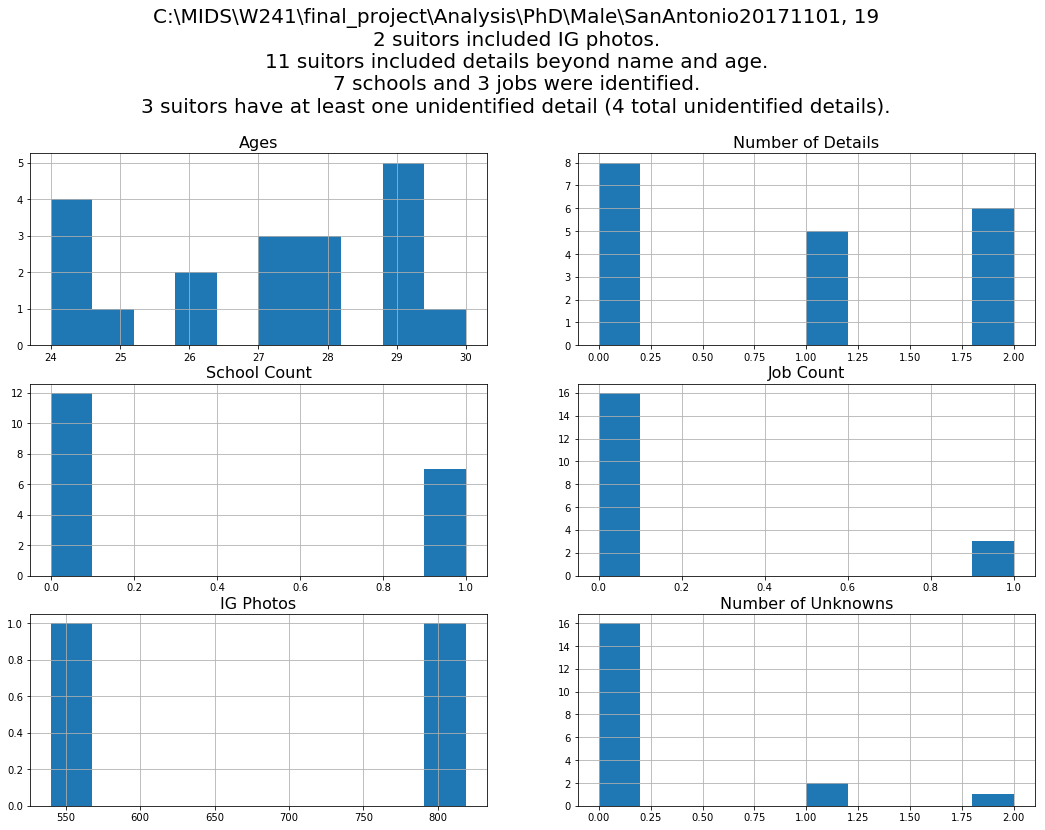

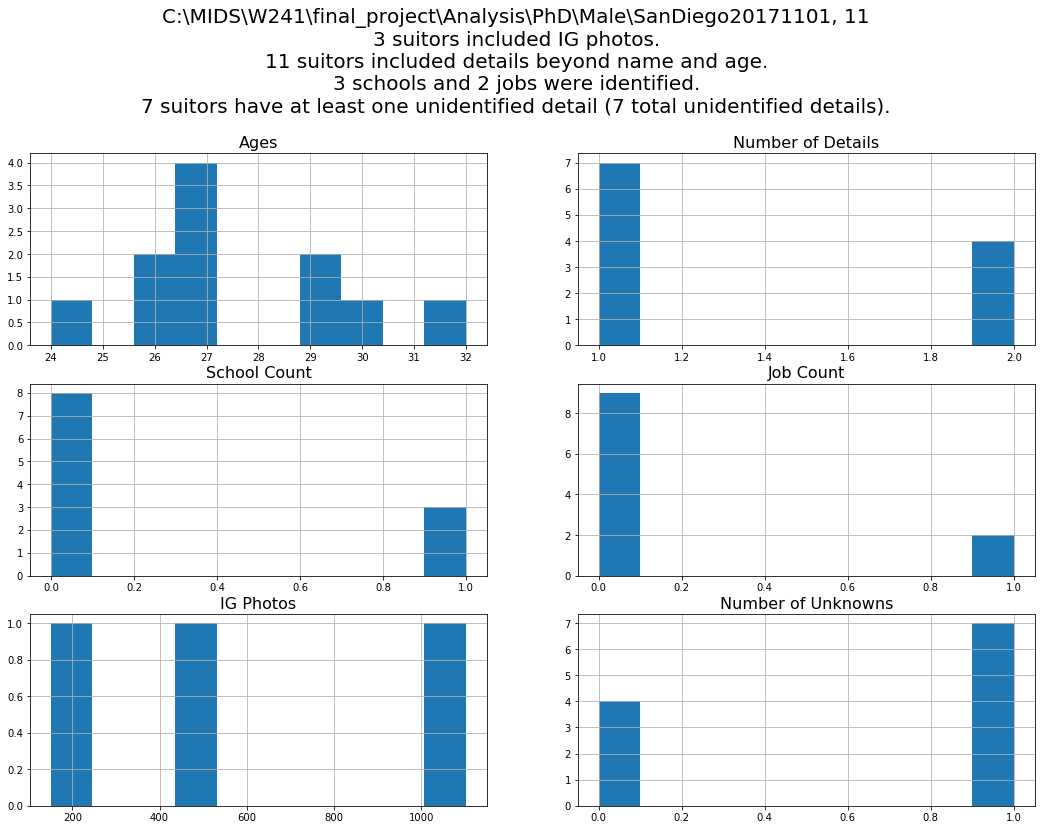

In [19]:
#plt.figure(figsize=(12,8))
fontdict = {'fontsize': 16}
for d in complete_records:
    edu_sex_city_df = complete_records[d][2]
    old_index = [f for f in range(len(edu_sex_city_df))]
    #print(len(edu_sex_city_df))
    edu_sex_city_df = edu_sex_city_df.drop(['filename', 'file_position'], axis=1)
    edu_sex_city_df = edu_sex_city_df.drop_duplicates()
    #print(edu_sex_city_df)
    #new_index = [f for f in range(len(edu_sex_city_df))]
    #edu_sex_city_df = edu_sex_city_df.reindex(new_index)
    edu_sex_city_df = edu_sex_city_df.reindex(old_index)
    #edu_sex_city_df = edu_sex_city_df.reindex()
    
    suitor_ages = edu_sex_city_df['age']
    num_suitors = len(complete_records[d][0])
    if suitor_ages.dtypes == 'object':
        for f in range(len(suitor_ages)):
            #print(type(f))
            if type(suitor_ages[f]) is str:
                suitor_ages[f] = float('nan')
    
    #edu_sex_city_df['num_details'].hist()
    num_suitors_with_details = sum(edu_sex_city_df['num_details'] > 0)
    
    #edu_sex_city_df['school'].hist()
    num_suitors_with_school = sum(edu_sex_city_df['school'] > 0)
    
    #edu_sex_city_df['job'].hist()
    num_suitors_with_job = sum(edu_sex_city_df['job'] > 0)
    
    #edu_sex_city_df['num_ig'].hist()
    #edu_sex_city_df['unknown'].hist()
    num_suitors_with_unknowns = sum(edu_sex_city_df['unknown'] > 0)
    total_unknowns = int(edu_sex_city_df['unknown'].sum())
        
    #suitor_num_ig = list(edu_sex_city_df['num_ig'])
    suitor_num_ig = list(edu_sex_city_df['num_ig'])
    #num_with_ig = sum((type(a) is int or (type(a) is float) and not math.isnan(a)) for a in suitor_num_ig)
    ig_counts = list(a for a in suitor_num_ig if (type(a) is int or (type(a) is float) and not math.isnan(a)))
    num_with_ig = len(ig_counts)
    #print(ig_counts)
    #print(num_with_ig, 'suitors included IG photos.')
    
    all_plots = plt.figure(d, figsize=(18,12))
    #plt.title(d + ', ' + str(num_suitors))
    sp = plt.subplot(321)
    #sp = all_plots.subplot(321)
    #print(len(edu_sex_city_df))
    edu_sex_city_df['age'].hist()
    sp.set_title('Ages', fontdict=fontdict)
    
    sp = plt.subplot(322)
    #sp = all_plots.subplot(322)
    edu_sex_city_df['num_details'].hist()
    sp.set_title('Number of Details', fontdict=fontdict)
    
    sp = plt.subplot(323)
    #sp = all_plots.subplot(323)
    edu_sex_city_df['school'].hist()
    sp.set_title('School Count', fontdict=fontdict)
    
    sp = plt.subplot(324)
    #sp = all_plots.subplot(324)
    edu_sex_city_df['job'].hist()
    sp.set_title('Job Count', fontdict=fontdict)
    
    sp = plt.subplot(325)
    #sp = all_plots.subplot(325)
    pd.Series(ig_counts).hist()
    sp.set_title('IG Photos', fontdict=fontdict)
    
    sp = plt.subplot(326)
    #sp = all_plots.subplot(326)
    edu_sex_city_df['unknown'].hist()
    sp.set_title('Number of Unknowns', fontdict=fontdict)
    
    #plt.title(d + ', ' + str(num_suitors))
    all_plots.suptitle(d + ', ' + str(num_suitors) + '\n' + \
                       str(num_with_ig) + ' suitors included IG photos.' + '\n' + \
                       str(num_suitors_with_details) + ' suitors included details beyond name and age.' + '\n' + \
                       str(num_suitors_with_school) + ' schools and ' + \
                       str(num_suitors_with_job) + ' jobs were identified.' + '\n' + \
                       str(num_suitors_with_unknowns) + ' suitors have at least one unidentified detail (' + \
                       str(total_unknowns) + ' total unidentified details).', y=1.05, fontsize=20)
    #print()

In [148]:
columns = ['Total Suitors', 'Suitors with IG', 'Suitors with Additional Details', \
          'Schools Identified', 'Jobs Identified', \
          'Suitors with Unknowns', 'Total Unknowns']
summary_df = pd.DataFrame([num_suitors, num_with_ig, num_suitors_with_details, \
                          num_suitors_with_school, num_suitors_with_job, \
                          num_suitors_with_unknowns, total_unknowns],index=columns)
summary_df.to_csv('summary.csv', header=False, index=True)

In [ ]:
plt.figure()
for d in complete_records:
    edu_sex_city_df = complete_records[d][2]
    edu_sex_city_df = edu_sex_city_df.drop(['filename', 'file_position'], axis=1)
    edu_sex_city_df = edu_sex_city_df.drop_duplicates()
    edu_sex_city_df = edu_sex_city_df.reindex(range(len(edu_sex_city_df)))
    suitor_ages = edu_sex_city_df['age']
    num_suitors = len(complete_records[d][0])
    if suitor_ages.dtypes == 'object':
        for f in range(len(suitor_ages)):
            #print(type(f))
            if type(suitor_ages[f]) is str:
                suitor_ages[f] = float('nan')
    plt.figure(d)
    #print(len(edu_sex_city_df))
    edu_sex_city_df['age'].hist()
    plt.title(d + ', ' + str(num_suitors))
    #print()

In [11]:
print(complete_records.keys())

dict_keys(['C:\\MIDS\\W241\\final_project\\Analysis\\NoEdu\\Female\\Chicago'])


In [14]:
unique_suitors = complete_records['C:\\MIDS\\W241\\final_project\\Analysis\\NoEdu\\Female\\Chicago'][0]
duplicate_suitors = complete_records['C:\\MIDS\\W241\\final_project\\Analysis\\NoEdu\\Female\\Chicago'][1]
suitor_df = complete_records['C:\\MIDS\\W241\\final_project\\Analysis\\NoEdu\\Female\\Chicago'][2]
all_entries = complete_records['C:\\MIDS\\W241\\final_project\\Analysis\\NoEdu\\Female\\Chicago'][3]

In [64]:
unique_suitors.index.names

FrozenList(['profile_image', 'name', 'age', 'detail_1', 'detail_2'])

In [53]:
type(unique_suitors)

pandas.core.series.Series

In [57]:
unique_suitors.index.get_level_values(4).tolist()

['University of Illinois at Chicago',
 'NO DATA',
 'NO DATA',
 'Robert Morris University Illinois',
 'University of Illinois at Urbana-Champaign',
 'NO DATA',
 'Mississippi State University',
 'Arizona State University',
 'University of Illinois at Urbana-Champaign',
 'University of Arkansas',
 'Indiana University',
 'Michigan State University',
 'Wayne State University School of Medicine',
 'NO DATA',
 'University of Illinois at Urbana-Champaign',
 'NO DATA',
 'NO DATA',
 'NO DATA',
 '1,025 Instagram Photos',
 'Indiana University (Bloomington)',
 'NO DATA',
 '120 Instagram Photos',
 'NO DATA',
 'University of Notre Dame',
 'NO DATA',
 '82 Instagram Photos',
 'Illinois State University',
 'Boston College',
 'Chicago-Kent College of Law',
 'NO DATA',
 'NO DATA',
 'University of Illinois at Urbana-Champaign',
 'The University of Edinburgh',
 "University of Nebraska\\'96Lincoln",
 'Washington University in St. Louis',
 'University of Illinois at Chicago',
 '33 Instagram Photos',
 'Univers

In [51]:
pd.DataFrame(unique_suitors).shape

(96, 1)

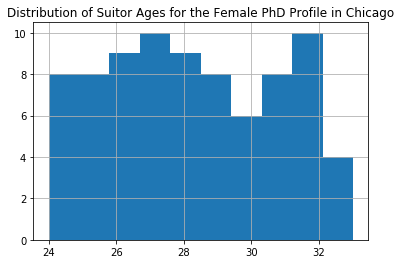

In [11]:
plt.figure()
phd_female_chicago['age'].hist()
plt.title('Distribution of Suitor Ages for the Female PhD Profile in Chicago')

In [37]:
phd_female_chicago.reindex(range(len(phd_female_chicago)))

name   age                                           detail_1  \
0        Jake  25.0                                        SEO Analyst   
1         Tom  25.0                              University of Chicago   
2        Ryan  28.0                                              Sales   
3       David  24.0                Audit Associate at Topel Forman LLC   
4        Avet  29.0                                  Software Engineer   
5       Chris  25.0                       York College of Pennsylvania   
6        Jose  31.0     University of Chicago Booth School of Business   
7        Adam  27.0                           Apollo Global Management   
8          CJ  27.0  Field Account Executive at SHI International C...   
9        Jeff  31.0           Personal Trainer at Equinox Fitness Club   
10    Michael  33.0                                  Boston University   
11       Luis  25.0                                    Richard J Daley   
12       Jose  31.0                   Florida International University   
13        Sam  31.0                                  Skiing the slopes   
14    Richard  29.0                                            NO DATA   
15        Jad  27.0                                      Chicago Booth   
16      Chris  30.0                                       Georgia Tech   
17      Ethan  24.0        Business Intelligence Analyst at Blackstone   
18  Alexander  30.0                   Virginia Commonwealth University   
19   Hirasuga  32.0                                             三菱地所設計   
20      Bobby  24.0                   Financial Analyst at Wells Fargo   
21        NaN   NaN                                                NaN   
22     Andrew  32.0                                Social Entrepreneur   
23     Selcuk  32.0                                             Nasiol   
24     Martez  29.0                                    General manager   
25        Riz  27.0                                            NO DATA   
26       Mike  29.0                                      CEO & Founder   
27     Daniel  31.0                        Logistics Manager at Aryzta   
28        NaN   NaN                                                NaN   
29       Jeff  32.0                                   Caterpillar Inc.   
..        ...   ...                                                ...   
50     Philip  29.0                                       Hope College   
51       Greg  27.0                                    Attorney-At-Law   
52      Ahmed  28.0          LUC School of Law
Northwestern University   
53    Shreyas  24.0                  University of Illinois at Chicago   
54      Ricky  25.0                          Success Barber School LLC   
55       Ryan  29.0                                                PwC   
56        NaN   NaN                                                NaN   
57      Tyler  30.0  Junior Bicycle Ambassador Coordinator at Chica...   
58        Jay  31.0                           University of Cincinnati   
59       Jack  25.0                            Imperial College London   
60       Dani  28.0                                            NO DATA   
61      Ranza  24.0                               Construction Trainer   
62        NaN   NaN                                                NaN   
63        Dom  25.0                                            NO DATA   
64        Sam  32.0                          Loyola University Chicago   
65       Omar  26.0                              Wilbur Wright College   
66      Jesús  30.0    Pontificia Universidad Católica Madre y Maestra   
67    Suyagya  28.0                      Bank of America Merrill Lynch   
68      Harry  32.0                              University of Glasgow   
69       Hank  25.0                               677 Instagram Photos   
70       Adam  26.0                                 Bradley University   
71        NaN   NaN                                                NaN   
72       Alan

In [6]:
for d in complete_records:
    print(d)
    print()

C:\MIDS\W241\final_project\Analysis\MD\Female\Chicago

C:\MIDS\W241\final_project\Analysis\MD\Female\Houston

C:\MIDS\W241\final_project\Analysis\MD\Female\LosAngeles

C:\MIDS\W241\final_project\Analysis\MD\Female\NewYork

C:\MIDS\W241\final_project\Analysis\MD\Female\Philadelphia

C:\MIDS\W241\final_project\Analysis\MD\Female\Phoenix

C:\MIDS\W241\final_project\Analysis\MD\Female\SanAntonio

C:\MIDS\W241\final_project\Analysis\MD\Female\SanDiego

C:\MIDS\W241\final_project\Analysis\MD\Male_original\Antonio

C:\MIDS\W241\final_project\Analysis\MD\Male_original\Chicago

C:\MIDS\W241\final_project\Analysis\MD\Male_original\Diego

C:\MIDS\W241\final_project\Analysis\MD\Male_original\Diego\Extras

C:\MIDS\W241\final_project\Analysis\MD\Male_original\Houston

C:\MIDS\W241\final_project\Analysis\MD\Male_original\LA

C:\MIDS\W241\final_project\Analysis\MD\Male_original\NY

C:\MIDS\W241\final_project\Analysis\MD\Male_original\NY\Extras

C:\MIDS\W241\final_project\Analysis\MD\Male_original\Phil